# Network Optimizations: Dual Annealing

Author: Jacob Parres-Gold (jacobparresgold@gmail.com)

Last Revised: 20231019

This notebook demonstrates how a dual annealing algorithm was used to optimize dimerization networks to perform desired functions.

In [2]:
import datetime
import itertools
import math
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats
import sys
import time

# EQTK to calculate equilibrium concentrations - install instructions here https://eqtk.github.io/getting_started/eqtk_installation.html
import eqtk

# Ray for parallelization - install instructions here https://docs.ray.io/en/latest/ray-overview/installation.html
import ray

In [3]:
# Load utility functions from dimer_network_utilities.py
utilities_path = str(pathlib.Path('C:\\Users','jacob','Local_Coding',\
                                  'ElowitzLab','Promiscuous_Networks','Notebooks','Paper_Notebooks')) # Directory of your utilities.py file
sys.path.append(utilities_path)
from dimer_network_utilities import *

In [3]:
# Initialize ray
_ = ray.init(ignore_reinit_error=True)

In [ ]:
# To shut down ray:
ray.shutdown()

In [4]:
# Define directory to save to
out_dir = str(pathlib.Path('C:\\Users','jacob','Downloads'))

if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [ ]:
# Plotting settings
rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],	
    "font.size":9,
    "axes.titlesize":9,
    "axes.labelsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9,
    "savefig.dpi": 900, 
    'figure.figsize': [6.0, 4.0],
    'figure.dpi': 150,
    'pdf.fonttype':42,
    'ps.fonttype':42,
})

In [ ]:
# Print package versions
import pkg_resources
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

print("Package versions:")
print("python={}".format(sys.version.split('|')[0].replace(' ','')))
for r in requirements:
    print("{}={}".format(*r))

Package versions:
python=3.8.13
eqtk=0.1.2
matplotlib=3.5.1
networkx=2.7.1
numpy=1.21.5
pandas=1.4.1
scipy=1.10.1


## Define Simulation Functions

In [ ]:
def run_eqtk(N, C0, params, acc_monomer_ind):
    """
    Run eqtk.solve given the input stoichiometry matrix, initial concentrations, and parameters.

    See eqtk.solve documentation for more details on the syntax.
    (https://eqtk.github.io/user_guide/generated/highlevel/eqtk.solve.html)

    Parameters
    ----------
    N : Array-like, shape (num_rxns, num_species)
        Input stoichiometry matrix
    C0 : Array-like, shape (num_simulation_points, num_species)
        Initial concentrations of all species for each simulation point.
        Accessory monomer levels will be set based on params.
    params : List-like, len num_combos_with_replacement(m,2) + (m-1)
        Parameters including Kij values and accessory monomer levels
    acc_monomer_ind : int  
        Index of accessory monomers in species list
    
    Returns
    -------
    C: Array-like
        Equilibrium concentrations of all species
    """
    num_rxns = N.shape[0]
    # Extract Kij values
    K = params[:num_rxns]
    # Set accessory monomer levels
    C0[:,acc_monomer_ind] = params[num_rxns:]

    return eqtk.solve(c0=C0, N=N, K=K)

In [ ]:
@ray.remote
def simulate_networks(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  
                

In [ ]:
def simulate_networks_manual(m, num_inputs, param_sets, t = 12, input_lb = -3, input_ub = 3):
    """
    Run simulations for dimer networks, over a titration of concentrations for each input monomer. 
    When >1 input monomers are varied (e.g., a 2D matrix), the first monomer is sampled outermost, 
    while the second is sampled inner to that.
    
    Parameters
    ----------
    m : int. 
        Number of monomer species in the network.
    num_inputs: int
        Number of monomers to count as inputs (those titrated). 
        E.g., if num_inputs=2, the first two monomers will be treated as inputs.
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. Log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species.Llog10 scale
    param_sets : Array-like, shape (num_sets, num_parameters)
        Parameter sets for simulating multiple dimerization networks.  
    Returns
    -------
    C0 : Array-like, shape (t, number of species)
        Initial concentration array used for eqtk.solve
    S_all : Array-like, shape (t, number of species, num_sets) 
        Equlibrium concentration of all species
        for all parameter sets and each input titration point.
        
    """
    # Create stoichiometry matrix 
    num_sets = param_sets.shape[0]
    N = make_nXn_stoich_matrix(m)
    num_rxns = N.shape[0]

    # Create initial concentration array
    M0_min = [input_lb]*num_inputs + [0] * (m-num_inputs) # Species concentrations at min of inputs
    M0_max = [input_ub]*num_inputs + [0] * (m-num_inputs) # Species concentrations at max of inputs
    num_conc = [t]*num_inputs + [1] * (m-num_inputs) # Number of concentrations to titrate for each species
    C0 = make_C0_grid(m, M0_min=M0_min, M0_max=M0_max, num_conc=num_conc) 
        
    acc_monomer_ind = np.arange(num_inputs,m) # Indices of accessory monomers
    S_all = np.zeros((C0.shape[0], C0.shape[1], num_sets))
    # For each parameter set, run eqtk.solve
    for pset_index, pset in enumerate(param_sets):
        S_all[:,:,pset_index] = run_eqtk(N, C0.copy(), pset, acc_monomer_ind)
    return C0,S_all  

## Create General Optimizers

In [ ]:
def cost_func(log_adjustable_params,adjustable_param_ids,initial_log_param_values,objective,allowed_outputs,m,num_inputs,t,input_lb,input_ub,return_as):
    '''
    Cost function to optimize a network by adjusting adjustable_params to fit a specific objective function, with least-squares in log space defining the cost.
    
    Parameters
    --------
    log_adjustable_params: Array-like of float
        Log10 of values of adjustable network parameters (K's, A's), which will be adjusted by the optimizer
    adjustable_param_ids: Array-like of int
        Out of total list of network parameters (K's, A's), the indices of the parameters being adjusted
    initial_log_param_values: Array-like of float
        Log10 of initial values of the network parameters (K's, A's) to use, including the values of the fixed parameters
    objective: Array-like, flattened
        A flattened array of the desired response
    allowed_outputs: Array-like of int
        Dimer IDs (starting at 0 for D11) allowed to be considered outputs
    m : int. 
        Number of monomer species. 
    num_inputs: Int
        Number of monomers to consider as inputs
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species. log10 scale
    return_as: "sumsquares" or "residuals"
        Whether to return a scalar sum-of-squares or a vector of residuals
        
    Returns
    --------
    Cost: Float
        Sum of squares between objective function and simulated response
    '''
    # Convert log params to linear params
    param_set = 10**(initial_log_param_values.copy())
    # Fill in adjustable param values
    param_set[adjustable_param_ids] = 10**log_adjustable_params
    # Simulate network
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    # Difference in log space is equivalent to log of quotient
    # Allow any dimer in allowed_outputs to be used
    costs = np.apply_along_axis(lambda row: np.sum(np.log10(np.divide(objective,row))**2),axis=1,arr=S_all)
    best_dimer = allowed_outputs[np.argmin(costs)]
    if return_as=='sumsquares':
        return np.min(costs)
    elif return_as=='residuals':
        return np.log10(np.divide(objective,S_all[best_dimer]))

In [ ]:
@ray.remote
def network_optimizer_dualannealing(adjustable_param_ids,initial_log_param_values,objective,allowed_outputs,m,K_log_range,A_log_range,num_inputs,\
                                    t,input_lb,input_ub,cost_func,maxiter=100,verbose=False):
    '''
    Cost function to optimize a network by adjusting adjustable_params to fit a specific objective function, with least-squares in log space defining the cost.
    
    Parameters
    --------
    adjustable_param_ids: Array-like of int
        Out of total list of network parameters (K's, A's), the indices of the parameters being adjusted
    initial_log_param_values: Array-like of float
        Log10 of initial values of the network parameters (K's, A's) to use, including the values of the fixed parameters
    objective: Array-like, flattened
        A flattened array of the desired response
    allowed_outputs: Array-like of int
        Dimer IDs (starting at 0 for D11) allowed to be considered outputs
    m : int. 
        Number of monomer species. 
    K_log_range: List of len 2
        In log space, the minimum and maximum allowed K values (affinities)
    A_log_range: List of len 2
        In log space, the minimum and maximum allowed A values (expression levels)
    num_inputs: Int
        Number of monomers to consider as inputs
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species. log10 scale
    cost_func: Function
        Function that takes the args* included below and outputs a scalar.
    maxiter: Int
        Maximum number of iterations. Default 100.
    verbose: Bool
        Whether to print function vals as minima are found
        
    Returns
    --------
    opt_result: Scipy OptimizeResult
        OptimizeResult.x: Array-like of float
            Optimized parameter values
        OptimizeResult.fun: Float
            Value of the cost at the optimized parameters
    '''
    # Based on adjustable_param_ids, calculate how many K's and A's are adjustable
    num_adjustable_Ks = np.where(np.isin(adjustable_param_ids,np.arange(num_combos_with_replacement(m,r=2))))[0].shape[0]
    num_adjustable_As = np.where(np.isin(adjustable_param_ids,np.arange(num_combos_with_replacement(m,r=2),num_combos_with_replacement(m,r=2)+m-1+1)))[0].shape[0]

    # Create bounds based on K_log_range and A_log_range
    bounds = [tuple(np.array(K_log_range,dtype=np.float64)) for K in range(num_adjustable_Ks)]+[tuple(np.array(A_log_range,dtype=np.float64)) for A in range(num_adjustable_As)]
    if verbose:
        # Create callback functio to announce the function value at each minimum
        callback = lambda x,f,context: print(f) if context==0 else False
    else:
        callback = None
    # Call scipy.optimize.dual_annealing
    opt_result = scipy.optimize.dual_annealing(cost_func,bounds = bounds,\
                                                args = (
                                                    adjustable_param_ids,
                                                    initial_log_param_values,
                                                    objective,
                                                    allowed_outputs,
                                                    m,
                                                    num_inputs,
                                                    t,
                                                    input_lb,
                                                    input_ub,
                                                    "sumsquares",
                                                    ),
                                               initial_temp=5230, # Default 5230. Range is (0.01, 5.e4]. Higher values facilitate a wider search of the energy landscape
                                               x0 = initial_log_param_values[adjustable_param_ids],
                                               maxiter=maxiter, # Default 1000
                                               callback = callback,
                                              )
    return opt_result

## Optimize 1D functions with one dimer

### Create Objectives

Run the cells for the functions you wish to optimize for

In [ ]:
objective_functions = {}

In [ ]:
input_lb = -3 # Lowest input titration point, log10 scale
input_ub = 3 # Highest input titration point, log10 scale
t = 30 # Number of titration points

x_points = np.logspace(input_lb,input_ub,t,endpoint=True) # Input titration points

In [ ]:
off_value = 1e-3 # Generic value for "off" states
on_value = 1e-1 # Generic value for "on" states

In [ ]:
objective = np.full((t,),on_value,dtype=np.float64)
objective[15:20] = off_value
objective_functions['trough'] = objective

In [ ]:
objective = np.full((t,),off_value,dtype=np.float64)
objective[15:20] = on_value
objective[20:25] = off_value
objective[25:] = on_value
objective_functions['updownup'] = objective

In [ ]:
objective = np.full((t,),on_value,dtype=np.float64)
objective[15:20] = off_value
objective[20:25] = on_value
objective[25:] = off_value
objective_functions['downupdown'] = objective

### Run Optimizations

In [ ]:
m = 3 # Network size

t=30 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

K_log_range = [-5,7] # Range for log10 scale affinity values
A_log_range = [-3,3] # Range for log10 scale accessory expression levels

round_low_concs_to = 10**-3 # Round low concentrations to this value
num_inputs =1 # Number of inputs to the network

# Which parameters is the optimizer allowed to adjust?
adjustable_param_ids = np.arange(num_combos_with_replacement(m,r=2)+(m-num_inputs))

rng = np.random.default_rng() # Random number generator

# Which dimers are allowed to be used as outputs?
allowed_outputs = np.arange(num_combos_with_replacement(m,r=2))

In [ ]:
num_initials = 8 # Number of initial guesses to try for each objective function
cost_funcs = [cost_func for x in objective_functions.keys()] # Cost functions to use for each objective function

In [ ]:
optim_futures = {}
opt_results_dualannealing = {}
opt_results_temp_dualannealing = {}
param_sets_dualannealing = {}
best_dimers_dualannealing = {}

# Iterate over objective functions
for name, objective,cost_func_temp in zip(objective_functions.keys(),objective_functions.values(),cost_funcs):
    optim_futures[name] = []
    # Iterate over initial guesses
    for init in range(num_initials):
        # Generate random initial guesses for the adjustable parameters
        initial_log_param_values = np.array(list(rng.uniform(K_log_range[0],K_log_range[1],size=(num_combos_with_replacement(m,r=2),)))+\
                       list(rng.uniform(A_log_range[0],A_log_range[1],size=(m-num_inputs,))))
        # Submit the optimization job
        optim_futures[name].append(network_optimizer_dualannealing.remote(
                                   adjustable_param_ids=adjustable_param_ids,\
                                   initial_log_param_values=initial_log_param_values,\
                                   objective=objective,\
                                   allowed_outputs=allowed_outputs,\
                                   m=m,\
                                   K_log_range=K_log_range,\
                                   A_log_range=A_log_range,\
                                   num_inputs=num_inputs,\
                                   t=t,\
                                   input_lb=input_lb,\
                                   input_ub=input_ub,\
                                   cost_func = cost_func_temp,\
                                   maxiter=500,\
                                   verbose=False,\
                                  ))

# Collect the results
for name, objective in objective_functions.items():
    opt_results_temp_dualannealing[name] = [0 for x in range(num_initials)]
    for init in range(num_initials):
        opt_results_temp_dualannealing[name][init] = ray.get(optim_futures[name][init])

# Iterate over objective functions
for name, objective in objective_functions.items():
    # Identify the best initial guess and retrieve the parameters
    best_init = np.argmin([x.fun for x in opt_results_temp_dualannealing[name]])
    opt_results_dualannealing[name] = opt_results_temp_dualannealing[name][best_init]
    param_set = 10**opt_results_dualannealing[name].x
    param_sets_dualannealing[name] = param_set
    # For this parameter set, identify the best dimer
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    # Difference in log space is equivalent to log of quotient
    costs = np.apply_along_axis(lambda row: np.sum(np.log10(np.divide(objective,row))**2),axis=1,arr=S_all)
    best_dimers_dualannealing[name] = allowed_outputs[np.argmin(costs)]

In [ ]:
for name in objective_functions.keys():
    np.save(str(pathlib.Path(out_dir,f'{m}M_{name}_optimized_paramset.npy')),param_sets_dualannealing[name])
    np.save(str(pathlib.Path(out_dir,f'{m}M_{name}_optimized_bestdimer.npy')),best_dimers_dualannealing[name])

### Plot Results:

In [ ]:
names_to_plot = list(objective_functions.keys()) # Which objective functions to plot

plot_all_dimers = False # Plot all dimers, not just the best one
save = False
plot_objective_only = False # Plot the objective function only, not the simulated data
highlight_dimer_of_interest = True # Make the dimer of interest solid black

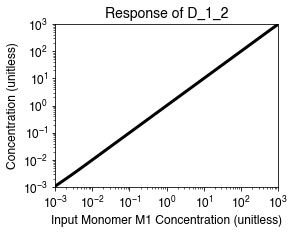

In [ ]:
for name in names_to_plot:
    if not plot_objective_only:
        # Retrieve the parameters and best dimer
        param_set = param_sets_dualannealing[name]
        best_dimer = best_dimers_dualannealing[name].copy()
        # Simulate the network
        C0,S_all  = simulate_networks_manual(m, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)

    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(4,3))
    axs = [axs]
    monomer_cmap = cm.get_cmap('Set2')
    dimer_cmap = cm.get_cmap('tab10')

    x_points = list(np.logspace(input_lb,input_ub,t,endpoint=True)) # Input titration points

    if plot_all_dimers:
        # Iterate over all species
        for species in range(number_of_species(m)):
            if (species==m+best_dimer) and highlight_dimer_of_interest:
                color='k'
                alpha=1
            else:
                if species<m:
                    color = monomer_cmap(species)
                else:
                    color = dimer_cmap(species-m)
                alpha=0.5
            axs[0].plot(x_points,S_all[:,species,0],marker=None,linestyle='-',color=color,\
                        alpha=alpha,lw=3)
    else:
        if not plot_objective_only:
            axs[0].plot(x_points,S_all[:,m+best_dimer,0],marker=None,linestyle='-',color='k',\
                            alpha=1,lw=3)
        else:
            axs[0].plot(x_points,objective_functions[name],marker=None,linestyle='-',color='k',\
                            alpha=1,lw=3)

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim([10**-3,10**3])
    axs[0].set_ylim([10**-3,10**3])
    _ = axs[0].set_xlabel('Input Monomer M1 Concentration (unitless)')
    _ = axs[0].set_ylabel('Concentration (unitless)')

    # Create legend
    if plot_all_dimers:
        patches={}
        for species in range(m):
            patches[f'M{species+1}'] = mpatches.Patch(facecolor=monomer_cmap(species),linewidth=0,linestyle='',alpha=0.5,label=f'Free M{species+1}')
        for species in range(m,number_of_species(m)):
            if np.all(S_all[:,species,0]<=1e-3):
                continue
            if species==m+best_dimer:
                color='k'
                alpha=1
            else:
                color = dimer_cmap(species-m)
                alpha=0.5
            patches[f'D{species+1}'] = mpatches.Patch(facecolor=color,linewidth=0,linestyle='',alpha=alpha,label=make_nXn_species_names(m = m)[species])

        leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
            handles=list(patches.values()),\
            edgecolor='white')
    else:
        _ = axs[0].set_title(f'Response of {make_nXn_species_names(m)[m+best_dimer]}')

    if save:
        if plot_all_dimers:
            dimers_label = '_all_dimers'
        else:
            dimers_label = ''
        filename = f'{m}M_{name}_responses{dimers_label}_optimized'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                    transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

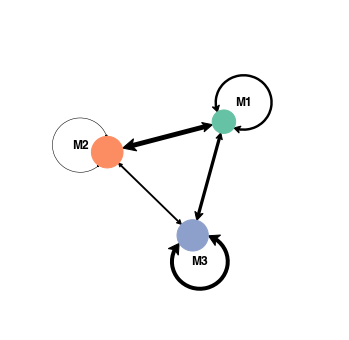

In [ ]:
for name in names_to_plot:
    fig, axs = make_network_plots_polygon(m=m, n_input=num_inputs,param_sets=np.expand_dims(param_set,axis=0), \
                                            univs_to_plot=np.array([0]),\
                                            ncols = 1,r_node = 1, r_loop = 0.4,\
                                            node_scales = [-3,3,100,1000], input_node_values=np.array([0]),\
                                            K_edge_scales = [-5,7,0.5,8],figsize=(6,6),input_cmap='Set2',\
                                            fontname = 'Helvetica',fontsize=12)

    fig.patch.set_facecolor('white')
    legend = fig.get_children()[2]
    legend.remove()
    if save:
        filename = f'{m}M_{name}_schematic_optimized'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Optimize Accessory Expression Levels For 1D Functions

### Create Objectives

Run the cells for the functions you wish to optimize for

In [ ]:
objective_functions = {}

In [ ]:
x_points = np.logspace(input_lb,input_ub,t,endpoint=True) # Input titration points

In [ ]:
off_value = 1e-3 # Generic value for "off" states
on_value = 1e-1 # Generic value for "on" states

In [ ]:
objective = np.full((t,),on_value,dtype=np.float64)
objective[15:20] = off_value
objective_functions['trough'] = objective

In [ ]:
objective = np.full((t,),off_value,dtype=np.float64)
objective[15:20] = on_value
objective[20:25] = off_value
objective[25:] = on_value
objective_functions['updownup'] = objective

In [ ]:
objective = np.full((t,),on_value,dtype=np.float64)
objective[15:20] = off_value
objective[20:25] = on_value
objective[25:] = off_value
objective_functions['downupdown'] = objective

### Run Optimizations

In [ ]:
m = 3 # Network size

t=30 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

A_log_range = [-3,3] # Range for log10 scale accessory expression levels

round_low_concs_to = 10**-3 # Round low concentrations to this value
num_inputs =1 # Number of inputs to the network

# Fix K (affinities) to particular values
log_fixed_params = np.log10([0.21371232386240424, 1.765945893676547, 143.95250554499685, 0.18323739582697354, \
                            144590.91741762645, 9.554323063366622, 2411387.073599409, 0.0015926912303464795, \
                            0.0027477840069857332, 0.0003299938301724921])

# Which parameters is the optimizer allowed to adjust?
adjustable_param_ids = np.arange(num_combos_with_replacement(m,r=2),num_combos_with_replacement(m,r=2)+(m-num_inputs))

# Which parameters is the optimizer NOT allowed to adjust?
fixed_param_ids = np.array(list(set(list(range(num_combos_with_replacement(m,r=2)+(m-num_inputs))))-set(adjustable_param_ids)))

rng = np.random.default_rng() # Random number generator

# Which dimers are allowed to be used as outputs?
# allowed_outputs = np.arange(num_combos_with_replacement(m,r=2))
allowed_outputs = np.array([9]) # Only D22 allowed

In [ ]:
num_initials = 8 # Number of initial conditions to try
cost_funcs = [cost_func for x in objective_functions.keys()] # Cost functions to use for each objective function

In [ ]:
optim_futures = {}
opt_results_dualannealing = {}
opt_results_temp_dualannealing = {}
param_sets_dualannealing = {}
best_dimers_dualannealing = {}

# Iterate over objective functions
for name, objective,cost_func_temp in zip(objective_functions.keys(),objective_functions.values(),cost_funcs):
    optim_futures[name] = []
    # Iterate over initial conditions
    for init in range(num_initials):
        # Initialize an array for the initial log10 scale parameter values
        initial_log_param_values=np.ones((num_combos_with_replacement(m,r=2)+(m-num_inputs),))
        # Fill in the fixed parameter values
        initial_log_param_values[fixed_param_ids] = log_fixed_params
        # Randomly initialize the adjustable parameter values
        initial_log_param_values[adjustable_param_ids] = rng.uniform(A_log_range[0],A_log_range[1],size=(m-num_inputs,))
        # Submit the optimization job
        optim_futures[name].append(network_optimizer_dualannealing.remote(
                                   adjustable_param_ids=adjustable_param_ids,\
                                   initial_log_param_values=initial_log_param_values,\
                                   objective=objective,\
                                   allowed_outputs=allowed_outputs,\
                                   m=m,\
                                   K_log_range=K_log_range,\
                                   A_log_range=A_log_range,\
                                   num_inputs=num_inputs,\
                                   t=t,\
                                   input_lb=input_lb,\
                                   input_ub=input_ub,\
                                   cost_func = cost_func_temp,\
                                   maxiter=1000,\
                                   verbose=False,\
                                  ))

# Collect the results
for name, objective in objective_functions.items():
    opt_results_temp_dualannealing[name] = [0 for x in range(num_initials)]
    for init in range(num_initials):
        opt_results_temp_dualannealing[name][init] = ray.get(optim_futures[name][init])

# Iterate over objective functions
for name, objective in objective_functions.items():
    # Identify the best initial condition and extract the parameters
    best_init = np.argmin([x.fun for x in opt_results_temp_dualannealing[name]])
    opt_results_dualannealing[name] = opt_results_temp_dualannealing[name][best_init]
    # Initialize an array for the log10 scale parameter values
    param_set=np.ones((num_combos_with_replacement(m,r=2)+(m-num_inputs),))
    # Fill in the adjustable parameter values
    param_set[adjustable_param_ids] = 10**opt_results_dualannealing[name].x
    # Fill in the fixed parameter values
    param_set[fixed_param_ids] = 10**log_fixed_params
    param_sets_dualannealing[name] = param_set
    # For these parameters, identify the best dimer to use as output
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    # Difference in log space is equivalent to log of quotient
    costs = np.apply_along_axis(lambda row: np.sum(np.log10(np.divide(objective,row))**2),axis=1,arr=S_all)
    best_dimers_dualannealing[name] = allowed_outputs[np.argmin(costs)]

print("Done")

In [ ]:
meta_name = 'stepup-stepdown-versatile'
for name in objective_functions.keys():
    np.save(str(pathlib.Path(out_dir,f'{m}M_{meta_name}_{name}_optimized_paramset.npy')),param_set)
    np.save(str(pathlib.Path(out_dir,f'{m}M_{meta_name}_{name}_optimized_bestdimer.npy')),best_dimer)

### Plot Results:

In [ ]:
names_to_plot = list(objective_functions.keys()) # Which objective functions to plot

plot_all_dimers = False # Plot all dimers, not just the best one
save = False
plot_objective_only = False # Plot the objective function only, not the simulated data
highlight_dimer_of_interest = True # Make the dimer of interest solid black

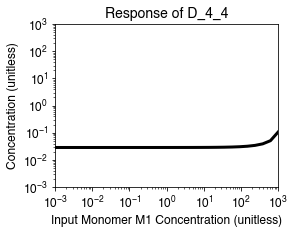

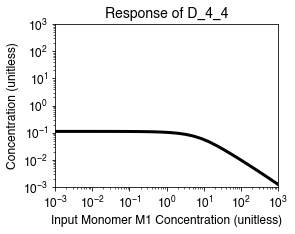

In [ ]:
for name in names_to_plot:
    if not plot_objective_only:
        # Retrieve the parameters and best dimer
        param_set = param_sets_dualannealing[name]
        best_dimer = best_dimers_dualannealing[name].copy()
        # Simulate the network
        C0,S_all  = simulate_networks_manual(m, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)

    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(4,3))
    axs = [axs]
    monomer_cmap = cm.get_cmap('Set2')
    dimer_cmap = cm.get_cmap('tab10')

    x_points = list(np.logspace(input_lb,input_ub,t,endpoint=True))

    if plot_all_dimers:
        for species in range(number_of_species(m)):
            if (species==m+best_dimer) and highlight_dimer_of_interest:
                color='k'
                alpha=1
            else:
                if species<m:
                    color = monomer_cmap(species)
                else:
                    color = dimer_cmap(species-m)
                alpha=0.5
            axs[0].plot(x_points,S_all[:,species,0],marker=None,linestyle='-',color=color,\
                        alpha=alpha,lw=3)
    else:
        if not plot_objective_only:
            axs[0].plot(x_points,S_all[:,m+best_dimer,0],marker=None,linestyle='-',color='k',\
                            alpha=1,lw=3)
        else:
            axs[0].plot(x_points,objective_functions[name],marker=None,linestyle='-',color='k',\
                            alpha=1,lw=3)

    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim([10**-3,10**3])
    axs[0].set_ylim([10**-3,10**3])
    _ = axs[0].set_xlabel('Input Monomer M1 Concentration (unitless)')
    _ = axs[0].set_ylabel('Concentration (unitless)')

    # Make the legend
    if plot_all_dimers:
        patches={}
        for species in range(m):
            patches[f'M{species+1}'] = mpatches.Patch(facecolor=monomer_cmap(species),linewidth=0,linestyle='',alpha=0.5,label=f'Free M{species+1}')
        for species in range(m,number_of_species(m)):
            if np.all(S_all[:,species,0]<=1e-3):
                continue
            if species==m+best_dimer:
                color='k'
                alpha=1
            else:
                color = dimer_cmap(species-m)
                alpha=0.5
            patches[f'D{species+1}'] = mpatches.Patch(facecolor=color,linewidth=0,linestyle='',alpha=alpha,label=make_nXn_species_names(m = m)[species])

        leg = fig.legend(bbox_to_anchor=(1, 0.5), loc='center left',facecolor='white',\
            handles=list(patches.values()),\
            edgecolor='white')
    else:
        _ = axs[0].set_title(f'Response of {make_nXn_species_names(m)[m+best_dimer]}')

    if save:
        if plot_all_dimers:
            dimers_label = '_all_dimers'
        else:
            dimers_label = ''
        filename = f'{m}M_{meta_name}_{name}_responses{dimers_label}_optimized'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                    transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

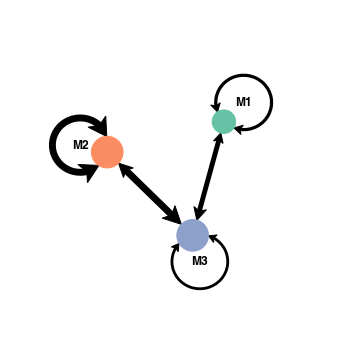

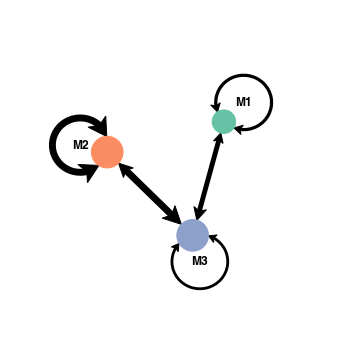

In [ ]:
for name in names_to_plot:
    fig, axs = make_network_plots_polygon(m=m, n_input=num_inputs,param_sets=np.expand_dims(param_set,axis=0), \
                                            univs_to_plot=np.array([0]),\
                                            ncols = 1,r_node = 1, r_loop = 0.4,\
                                            node_scales = [-3,3,100,1000], input_node_values=np.array([0]),\
                                            K_edge_scales = [-5,7,0.5,8],figsize=(6,6),input_cmap='Set2',\
                                            fontname = 'Helvetica',fontsize=12)

    fig.patch.set_facecolor('white')
    legend = fig.get_children()[2]
    legend.remove()
    if save:
        plt.savefig(str(pathlib.Path(out_dir,f'{m}M_{meta_name}_{name}_schematic_optimized.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,f'{m}M_{meta_name}_{name}_schematic_optimized.png')),dpi=900,bbox_inches='tight')

## Optimize 2D functions with one dimer

### Create Objectives

In [1]:
objective_functions = {}

In [6]:
t = 12 # Number of input titration points
input_lb = -3 # Lower bound on input titration, log10 scale
input_ub = 3 # Upper bound on input titration, log10 scale

#### Logic Gates:

In [7]:
desired_transition_val = 1e0 # Desired point at which the input is considered "on"
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
# Find the closest x point to the desired transition value
closest_x_point_id = np.argmin(np.abs(np.log10(x_points)-np.log10(desired_transition_val)))

In [8]:
off_value = 10**input_lb # Value of output to consider as "off"
on_value = 1e-1 # Value of output to consider as "on"

In [9]:
# Inputs (A,B): (0,0), (1,0), (0,1), (1,1) 
logic_gates = {
               'AND':[0,0,0,1],
               'NAND':[1,1,1,0],
               'OR':[0,1,1,1],
               'XOR':[0,1,1,0],
               'NOR':[1,0,0,0],
               'XNOR':[1,0,0,1],
               'ANOTB':[0,1,0,0],
              }

for name, responses in logic_gates.items():
    objective = np.full((t,t),off_value,dtype=np.float64)
    objective[:closest_x_point_id,:closest_x_point_id] = [off_value,on_value][responses[0]]
    objective[closest_x_point_id:,:closest_x_point_id] = [off_value,on_value][responses[1]]
    objective[:closest_x_point_id,closest_x_point_id:] = [off_value,on_value][responses[2]]
    objective[closest_x_point_id:,closest_x_point_id:] = [off_value,on_value][responses[3]]
    objective = objective.flatten()
    objective_functions[name] = objective

#### More complex functions:

In [10]:
off_value = 10**input_lb # Value of output to consider as "off"
on_value = 1e-1 # Value of output to consider as "on"

In [11]:
objective = np.full((t,t),off_value,dtype=np.float64)
zipped = np.array(list(zip(np.arange(6,t),np.arange(6,t)))).T
objective[zipped[0],zipped[1]] = on_value
objective = objective.flatten()
objective_functions['A=B'] = objective

In [12]:
objective = np.full((t,t),on_value,dtype=np.float64)
zipped = np.array(list(zip(np.arange(t),np.arange(t)))).T
objective[zipped[0],zipped[1]] = off_value
objective = objective.flatten()
objective_functions['A!=B'] = objective

In [13]:
objective = np.full((t,t),off_value,dtype=np.float64)
bump_start = 6
bump_end = 8 # Inclusive
objective[bump_start:bump_end+1,bump_start:bump_end+1] = on_value
objective = objective.flatten()
objective_functions['double_bandpass'] = objective

In [14]:
max_log_ratio = input_ub-input_lb
min_log_ratio = input_lb-input_ub
min_output = 1e-3
max_output= 1e1
def sigmoid_of_ratio(log_ratio,min_log_ratio,max_log_ratio,log_min_output,log_max_output):
    norm_input = (log_ratio-min_log_ratio)/(max_log_ratio-min_log_ratio)
    EC50 = 0.5
    n = 4
    x = (10**norm_input)/(10**EC50)
    return log_min_output + (((log_max_output-log_min_output)*(x**n))/(1+(x**n)))

objective = np.full((t,t),off_value,dtype=np.float64)
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
for x1 in range(t):
    log_ratios = np.log10(np.array([x_points[x1]/x_points[x2] for x2 in range(t)]))
    objective[x1,:] = 10**np.apply_along_axis(sigmoid_of_ratio, axis=0, arr=log_ratios, \
                                          min_log_ratio=min_log_ratio,max_log_ratio=max_log_ratio,\
                                          log_min_output=np.log10(min_output),log_max_output=np.log10(max_output))

# Turn off at low input
objective[:4,:4] = min_output
objective = objective.flatten()
objective_functions['ratio'] = objective

#### Temporary: Targets

In [72]:
custom_2D_targets = np.array(list(objective_functions.values()))
objective_names = list(objective_functions.keys())

t = 12 # Number of input titration points
input_lb = -3 # Lower bound on input titration, log10 scale
input_ub = 3 # Upper bound on input titration, log10 scale

input_vals = np.full((t,t,2),-1,dtype=np.float64)
input_vals[:,:,0] = np.tile(np.logspace(input_lb,input_ub,t,endpoint=True),reps=(t,1)).T
input_vals[:,:,1] = np.tile(np.logspace(input_lb,input_ub,t,endpoint=True),reps=(t,1))

np.save(str(pathlib.Path(out_dir,f'custom_2D_target_names.npy')),objective_names)
np.save(str(pathlib.Path(out_dir,f'custom_2D_targets.npy')),custom_2D_targets)
np.save(str(pathlib.Path(out_dir,f'2D_input_vals.npy')),input_vals)

'''
custom_2D_target_names.npy
    Array of strings, each string is the name of the objective function
custom_2D_targets.npy
    Array of shape (n_obj,t**2) where n_obj is the number of objective functions and t is the number of titration points for each input.
    Each row is the flattened objective function, in the default 'C' order of ndarray.flatten()
2D_input_vals.npy
    Array of shape (t,t,2) where the first dimension is the first input titration, the second dimension is the second input titration,
    and the third dimension is the identity of the input (M1 or M2)

'''

### Run Optimizations

In [ ]:
m = 8 # Network size

t=12 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

K_log_range = [-5,7] # Range for log10 scale affinity values
A_log_range = [-3,3] # Range for log10 scale accessory expression levels

round_low_concs_to = 10**-3 # Round low concentrations to this value
num_inputs = 2 # Number of inputs to the network

# Which parameters is the optimizer allowed to adjust?
adjustable_param_ids = np.arange(num_combos_with_replacement(m,r=2)+(m-num_inputs))

rng = np.random.default_rng() # Random number generator

# Which dimers are allowed to be used as outputs?
allowed_outputs = np.arange(num_combos_with_replacement(m,r=2))

In [ ]:
num_initials = 8 # Number of initial guesses to try for each objective function
cost_funcs = [cost_func for x in objective_functions.keys()] # Cost functions to use for each objective function

In [ ]:
optim_futures = {}
opt_results_dualannealing = {}
opt_results_temp_dualannealing = {}
param_sets_dualannealing = {}
best_dimers_dualannealing = {}

# Iterate over objective functions
for name, objective,cost_func_temp in zip(objective_functions.keys(),objective_functions.values(),cost_funcs):
    optim_futures[name] = []
    # Iterate over initial guesses
    for init in range(num_initials):
        # Generate random initial guesses for the adjustable parameters
        initial_log_param_values = np.array(list(rng.uniform(K_log_range[0],K_log_range[1],size=(num_combos_with_replacement(m,r=2),)))+\
                       list(rng.uniform(A_log_range[0],A_log_range[1],size=(m-num_inputs,))))
        # Submit the optimization job
        optim_futures[name].append(network_optimizer_dualannealing.remote(
                                   adjustable_param_ids=adjustable_param_ids,\
                                   initial_log_param_values=initial_log_param_values,\
                                   objective=objective,\
                                   allowed_outputs=allowed_outputs,\
                                   m=m,\
                                   K_log_range=K_log_range,\
                                   A_log_range=A_log_range,\
                                   num_inputs=num_inputs,\
                                   t=t,\
                                   input_lb=input_lb,\
                                   input_ub=input_ub,\
                                   cost_func = cost_func_temp,\
                                   maxiter=500,\
                                   verbose=False,\
                                  ))

# Collect the results
for name, objective in objective_functions.items():
    opt_results_temp_dualannealing[name] = [0 for x in range(num_initials)]
    for init in range(num_initials):
        opt_results_temp_dualannealing[name][init] = ray.get(optim_futures[name][init])

# Iterate over objective functions
for name, objective in objective_functions.items():
    # Identify the best initial guess and retrieve the parameters
    best_init = np.argmin([x.fun for x in opt_results_temp_dualannealing[name]])
    opt_results_dualannealing[name] = opt_results_temp_dualannealing[name][best_init]
    param_set = 10**opt_results_dualannealing[name].x
    param_sets_dualannealing[name] = param_set
    # For this parameter set, identify the best dimer
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    # Difference in log space is equivalent to log of quotient
    costs = np.apply_along_axis(lambda row: np.sum(np.log10(np.divide(objective,row))**2),axis=1,arr=S_all)
    best_dimers_dualannealing[name] = allowed_outputs[np.argmin(costs)]

In [ ]:
for name in objective_functions.keys():
    np.save(str(pathlib.Path(out_dir,f'{m}M_{name}_optimized_paramset.npy')),param_sets_dualannealing[name])
    np.save(str(pathlib.Path(out_dir,f'{m}M_{name}_optimized_bestdimer.npy')),best_dimers_dualannealing[name].copy())

### Plot Results

In [ ]:
names_to_plot = list(objective_functions.keys()) # Which objective functions to plot

plot_all_dimers = False # Plot all dimers, not just the best one
save = False
plot_objective_only = False # Plot the objective function only, not the simulated data

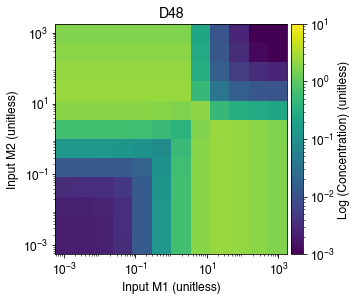

In [ ]:
for name in names_to_plot:
    if not plot_objective_only:
        # Retrieve the parameters and best dimer
        param_set = param_sets_dualannealing[name]
        best_dimer = best_dimers_dualannealing[name].copy()
        # Simulate the network
        C0,S_all  = simulate_networks_manual(m, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)

    if plot_all_dimers:
        ncols = 5
        nrows = (number_of_species(m=m)//ncols)+1
        fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(ncols*4,nrows*3))
    else:
        ncols=1
        fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(4.3,4))
        axs = np.array([[axs]])
    
    cmap = cm.get_cmap('viridis')

    # Input titration points
    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
    
    for species in range(number_of_species(m)):
        if (not plot_all_dimers) and species>0:
            continue
        row = species//ncols
        col = species%ncols
        # Need to take transpose so that M1 appears on X-axis
        if plot_all_dimers:
            matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,species,0].reshape((t,t)).T,\
                                         cmap = cmap,norm=mpl.colors.LogNorm(vmin=10**input_lb,vmax=10**input_ub),\
                                             shading = 'gouraud')
            # shading='gouraud' or shading='nearest'
        else:
            if plot_objective_only:
                matrix = axs[row,col].pcolormesh(x_points,x_points,objective_functions[name].reshape((t,t)).T,\
                                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=10**input_lb,vmax=10**input_ub),\
                                             shading = 'gouraud')
                # shading='gouraud' or shading='nearest'
            else:
                matrix = axs[row,col].pcolormesh(x_points,x_points,S_all[:,m+best_dimer,0].reshape((t,t)).T,\
                                             cmap = cmap,norm=mpl.colors.LogNorm(vmin=10**input_lb,vmax=10**1),\
                                             shading = 'gouraud')
                # shading='gouraud' or shading='nearest'
        axs[row,col].xaxis.set_ticks_position("bottom")
        axs[row,col].set_xscale('log')
        axs[row,col].set_yscale('log')
        axs[row,col].set_xlabel(f'Input M1 (unitless)')
        axs[row,col].set_ylabel(f'Input M2 (unitless)')
        axs[row,col].set_xticks([1e-3,1e-1,1e1,1e3])
        axs[row,col].set_yticks([1e-3,1e-1,1e1,1e3])
        axs[row,col].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        axs[row,col].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
        if plot_all_dimers:
            _ = axs[row,col].set_title(make_nXn_species_names(m=m)[species])
        else:
            _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+best_dimer])
        # Add colorbar
        divider = make_axes_locatable(axs[row,col])
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(matrix,cax=cax1,label='Log (Concentration) (unitless)')

    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.7,
                        hspace=0.5)
    if plot_all_dimers:
        for extra_ax in range(number_of_species(m),nrows*ncols):
            row = extra_ax//ncols
            col = extra_ax-(row*ncols)
            axs[row,col].remove()

    if save:
        if plot_all_dimers:
            dimers_label = '_all_dimers'
        else:
            dimers_label = ''
        filename = f'{m}M_{name}_responses{dimers_label}_optimized'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),\
                    transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

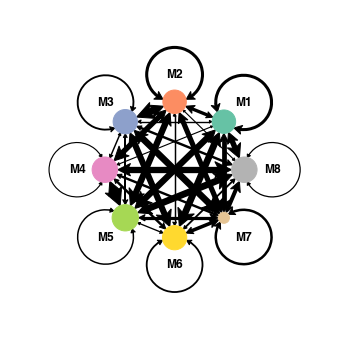

In [ ]:
for name in names_to_plot:
    param_set = param_sets_dualannealing[name]
    best_dimer = best_dimers_dualannealing[name]
    fig, axs = make_network_plots_polygon(m=m, n_input=num_inputs,param_sets=np.expand_dims(param_set,axis=0), \
                                            univs_to_plot=np.array([0]),\
                                            ncols = 1,r_node = 1, r_loop = 0.4,\
                                            node_scales = [-3,3,100,1000], input_node_values=np.array([0,0]),\
                                            K_edge_scales = [-5,7,0.5,8],figsize=(6,6),input_cmap='Set2',\
                                            fontname = 'Helvetica',fontsize=12)

    fig.patch.set_facecolor('white')
    legend = fig.get_children()[2]
    legend.remove()
    if save:
        filename = f'{m}M_{name}_schematic_optimized'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Optimize 2D Functions with Combinations of Dimers

We want to allow "feasible" combinations of dimers, which could be achieved by putting split effector domains on multiple monomers.

### Create Objectives

In [ ]:
objective_functions = {}

#### Logic Gates:

In [ ]:
desired_transition_val = 1e0 # Desired point at which the input is considered "on"
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
# Find the closest x point to the desired transition value
closest_x_point_id = np.argmin(np.abs(np.log10(x_points)-np.log10(desired_transition_val)))

In [ ]:
off_value = 10**input_lb # Value of output to consider as "off"
on_value = 1e-1 # Value of output to consider as "on"

In [ ]:
t = 12 # Number of input titration points

In [ ]:
# Inputs (A,B): (0,0), (1,0), (0,1), (1,1) 
logic_gates = {
               'AND':[0,0,0,1],
               'NAND':[1,1,1,0],
               'OR':[0,1,1,1],
               'XOR':[0,1,1,0],
               'NOR':[1,0,0,0],
               'XNOR':[1,0,0,1],
               'ANOTB':[0,1,0,0],
              }

for name, responses in logic_gates.items():
    objective = np.full((t,t),off_value,dtype=np.float64)
    objective[:closest_x_point_id,:closest_x_point_id] = [off_value,on_value][responses[0]]
    objective[closest_x_point_id:,:closest_x_point_id] = [off_value,on_value][responses[1]]
    objective[:closest_x_point_id,closest_x_point_id:] = [off_value,on_value][responses[2]]
    objective[closest_x_point_id:,closest_x_point_id:] = [off_value,on_value][responses[3]]
    objective = objective.flatten()
    objective_functions[name] = objective

#### More complex functions:

In [ ]:
off_value = 10**input_lb # Value of output to consider as "off"
on_value = 1e-1 # Value of output to consider as "on"

In [ ]:
objective = np.full((t,t),off_value,dtype=np.float64)
zipped = np.array(list(zip(np.arange(6,t),np.arange(6,t)))).T
objective[zipped[0],zipped[1]] = on_value
objective = objective.flatten()
objective_functions['A=B'] = objective

In [ ]:
objective = np.full((t,t),on_value,dtype=np.float64)
zipped = np.array(list(zip(np.arange(t),np.arange(t)))).T
objective[zipped[0],zipped[1]] = off_value
objective = objective.flatten()
objective_functions['A!=B'] = objective

In [ ]:
objective = np.full((t,t),off_value,dtype=np.float64)
bump_start = 6
bump_end = 8 # Inclusive
objective[bump_start:bump_end+1,bump_start:bump_end+1] = on_value
objective = objective.flatten()
objective_functions['double_bandpass'] = objective

In [ ]:
max_log_ratio = input_ub-input_lb
min_log_ratio = input_lb-input_ub
min_output = 1e-3
max_output= 1e1
def sigmoid_of_ratio(log_ratio,min_log_ratio,max_log_ratio,log_min_output,log_max_output):
    norm_input = (log_ratio-min_log_ratio)/(max_log_ratio-min_log_ratio)
    EC50 = 0.5
    n = 4
    x = (10**norm_input)/(10**EC50)
    return log_min_output + (((log_max_output-log_min_output)*(x**n))/(1+(x**n)))

objective = np.full((t,t),off_value,dtype=np.float64)
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
for x1 in range(t):
    log_ratios = np.log10(np.array([x_points[x1]/x_points[x2] for x2 in range(t)]))
    objective[x1,:] = 10**np.apply_along_axis(sigmoid_of_ratio, axis=0, arr=log_ratios, \
                                          min_log_ratio=min_log_ratio,max_log_ratio=max_log_ratio,\
                                          log_min_output=np.log10(min_output),log_max_output=np.log10(max_output))

# Turn off at low input
objective[:4,:4] = min_output
objective = objective.flatten()
objective_functions['ratio'] = objective

### Create Functions for Optimization with Combinations of Dimers

In [ ]:
def cost_func_sumofdimers(log_adjustable_params,adjustable_param_ids,initial_log_param_values,objective,allowed_outputs,active_dimer_sets,m,num_inputs,t,input_lb,input_ub,return_as):
    '''
    Cost function to optimize a network by adjusting adjustable_params to fit a specific objective function, with least-squares in log space defining the cost.
    
    Parameters
    --------
    log_adjustable_params: Array-like of float
        Log10 of values of adjustable network parameters (K's, A's), which will be adjusted by the optimizer
    adjustable_param_ids: Array-like of int
        Out of total list of network parameters (K's, A's), the indices of the parameters being adjusted
    initial_log_param_values: Array-like of float
        Log10 of initial values of the network parameters (K's, A's) to use, including the values of the fixed parameters
    objective: Array-like, flattened
        A flattened array of the desired response
    allowed_outputs: Array-like of int
        Dimer IDs (starting at 0 for D11) allowed to be considered outputs
    active_dimer_sets: Array-like of int, shape (n_options, num_active_dimers_per_option)
        Sets of active dimers to be summed up.
    m : int. 
        Number of monomer species. 
    num_inputs: Int
        Number of monomers to consider as inputs
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species. log10 scale
    return_as: "sumsquares" or "residuals"
        Whether to return a scalar sum-of-squares or a vector of residuals
        
    Returns
    --------
    Cost: Float
        Sum of squares between objective function and simulated response
    '''
    param_set = 10**(initial_log_param_values.copy())
    param_set[adjustable_param_ids] = 10**log_adjustable_params
    # Simulate network
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    costs = np.zeros((active_dimer_sets.shape[0],))
    # Iterate over possible sets of active dimers
    for i in range(active_dimer_sets.shape[0]):
        # Difference in log space is equivalent to log of quotient
        costs[i] = np.sum(np.log10(np.divide(objective,np.sum(S_all[active_dimer_sets[i],:],axis=0)))**2)
    # Find the best set of active dimers
    best_option_id = np.argmin(costs)
    best_dimers = [allowed_outputs[x] for x in active_dimer_sets[best_option_id]]
    if return_as=='sumsquares':
        return np.min(costs)
    elif return_as=='residuals':
        return np.log10(np.divide(objective,S_all[best_dimers[0],:]+S_all[best_dimers[1],:]))

In [ ]:
@ray.remote
def network_optimizer_dualannealing_sumofdimers(adjustable_param_ids,initial_log_param_values,objective,allowed_outputs,num_monomers_effectorA,num_monomers_effectorB,\
                                                m,K_log_range,A_log_range,num_inputs,\
                                                t,input_lb,input_ub,cost_func,maxiter=100,verbose=False):
    '''
    Cost function to optimize a network by adjusting adjustable_params to fit a specific objective function, with least-squares in log space defining the cost.
    
    Parameters
    --------
    adjustable_param_ids: Array-like of int
        Out of total list of network parameters (K's, A's), the indices of the parameters being adjusted
    initial_log_param_values: Array-like of float
        Log10 of initial values of the network parameters (K's, A's) to use, including the values of the fixed parameters
    objective: Array-like, flattened
        A flattened array of the desired response
    allowed_outputs: Array-like of int
        Dimer IDs (starting at 0 for D11) allowed to be considered outputs
    num_monomers_effectorA, num_monomers_effectorB: Int
        We are summing together dimers by placing split effector domains (A, B) on several monomers. Number of monomers bearing 
        split effector domain half A and half B.
    m : int. 
        Number of monomer species. 
    K_log_range: List of len 2
        In log space, the minimum and maximum allowed K values (affinities)
    A_log_range: List of len 2
        In log space, the minimum and maximum allowed A values (expression levels)
    num_inputs: Int
        Number of monomers to consider as inputs
    t : int. Default 12. 
        Number of values to titrate each input monomer species. 
        Values spaced evenly on a log10 scale
    input_lb : int. Default -3
        lower bound for titrating the input monomer species. log10 scale
    input_ub : int. Default 3
        upper bound for titrating the input monomer species. log10 scale
    cost_func: Function
        Function that takes the args* included below and outputs a scalar.
    maxiter: Int
        Maximum number of iterations. Default 100.
    verbose: Bool
        Whether to print function vals as minima are found
        
    Returns
    --------
    opt_result: Scipy OptimizeResult
        OptimizeResult.x: Array-like of float
            Optimized parameter values
        OptimizeResult.fun: Float
            Value of the cost at the optimized parameters
    '''
    num_adjustable_Ks = np.where(np.isin(adjustable_param_ids,np.arange(num_combos_with_replacement(m,r=2))))[0].shape[0]
    num_adjustable_As = np.where(np.isin(adjustable_param_ids,np.arange(num_combos_with_replacement(m,r=2),num_combos_with_replacement(m,r=2)+m-1+1)))[0].shape[0]
    bounds = [tuple(np.array(K_log_range,dtype=np.float64)) for K in range(num_adjustable_Ks)]+[tuple(np.array(A_log_range,dtype=np.float64)) for A in range(num_adjustable_As)]
    if verbose:
        callback = lambda x,f,context: print(f) if context==0 else False
    else:
        callback = None
    # Calculate possible combinations of monomers with each half of an effector domain
    dimer_constitutents = list(itertools.combinations_with_replacement(range(m),r=2))
    # Options who which monomers to have effector half A
    monomers_with_effectorA_options = list(itertools.combinations(range(m),r=num_monomers_effectorA))
    # All options for which monomers will have effector half A and which will have effector half B
    # Allow homodimers - same monomer can have both A and B
    # Rather than doing all combinations of every monomer, only consider bare minimum of inputs and min number of accessories
        # This is to help constrain the search space a little - since all accessories are equivalent, if can only use 2 accessories, 
        # only allow combos with M3 and M4
    all_options = list(itertools.product(itertools.combinations(range(num_inputs+num_monomers_effectorA),r=num_monomers_effectorA),\
                                             itertools.combinations(range(num_inputs+num_monomers_effectorB),r=num_monomers_effectorB)))
    # For each option, which dimers are active
    active_dimer_sets = np.array([tuple([dimer_constitutents.index(tuple(sorted(x))) for x in itertools.product(option[0],option[1])])\
                 for option in all_options])
    # Then run optimization:
    opt_result = scipy.optimize.dual_annealing(cost_func,bounds = bounds,\
                                                args = (
                                                    adjustable_param_ids,
                                                    initial_log_param_values,
                                                    objective,
                                                    allowed_outputs,
                                                    active_dimer_sets,
                                                    m,
                                                    num_inputs,
                                                    t,
                                                    input_lb,
                                                    input_ub,
                                                    "sumsquares",
                                                    ),
                                               initial_temp=5230, # Default 5230. Range is (0.01, 5.e4]. Higher values facilitate a wider search of the energy landscape
                                               x0 = initial_log_param_values[adjustable_param_ids],
                                               maxiter=maxiter, # Default 1000
                                               callback = callback,
                                              )
    return opt_result

### Run Optimizations

In [ ]:
m = 8 # Network size

t=12 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

K_log_range = [-5,7] # Range for log10 scale affinity values
A_log_range = [-3,3] # Range for log10 scale accessory expression levels

round_low_concs_to = 10**-3 # Round low concentrations to this value
num_inputs = 2 # Number of inputs to the network

# Which parameters is the optimizer allowed to adjust?
adjustable_param_ids = np.arange(num_combos_with_replacement(m,r=2)+(m-num_inputs))

rng = np.random.default_rng() # Random number generator

# Which dimers are allowed to be used as outputs?
allowed_outputs = np.arange(num_combos_with_replacement(m,r=2))

# We are summing together dimers by placing split effector domains (A, B) on several monomers. 
# Number of monomers bearing split effector domain half A and half B.
num_monomers_effectorA=2
num_monomers_effectorB=2

In [ ]:
num_initials = 8 # Number of initial guesses to try for each objective function
cost_funcs = [cost_func for x in objective_functions.keys()] # Cost functions to use for each objective function

In [ ]:
optim_futures = {}
opt_results_dualannealing = {}
opt_results_temp_dualannealing = {}
param_sets_dualannealing = {}
best_dimers_dualannealing = {}

# Iterate over objective functions
for name, objective,cost_func_temp in zip(objective_functions.keys(),objective_functions.values(),cost_funcs):
    optim_futures[name] = []
    # Iterate over initial guesses
    for init in range(num_initials):
        # Generate random initial guesses for the adjustable parameters
        initial_log_param_values = np.array(list(rng.uniform(K_log_range[0],K_log_range[1],size=(num_combos_with_replacement(m,r=2),)))+\
                       list(rng.uniform(A_log_range[0],A_log_range[1],size=(m-num_inputs,))))
        # Submit optimization job
        optim_futures[name] = network_optimizer_dualannealing_sumofdimers.remote(
                                       adjustable_param_ids=adjustable_param_ids,\
                                       initial_log_param_values=initial_log_param_values,\
                                       objective=objective,\
                                       allowed_outputs=allowed_outputs,\
                                       num_monomers_effectorA=num_monomers_effectorA,\
                                       num_monomers_effectorB=num_monomers_effectorB,\
                                       m=m,\
                                       K_log_range=K_log_range,\
                                       A_log_range=A_log_range,\
                                       num_inputs=num_inputs,\
                                       t=t,\
                                       input_lb=input_lb,\
                                       input_ub=input_ub,\
                                       cost_func = cost_func_temp,\
                                       maxiter=200,\
                                       verbose=False,\
                                      )

# Get results
for name, objective in objective_functions.items():
    opt_results_temp_dualannealing[name] = [0 for x in range(num_initials)]
    for init in range(num_initials):
        opt_results_temp_dualannealing[name][init] = ray.get(optim_futures[name][init])

# Iterate over objective functions
for name, objective in objective_functions.items():
    # Identify the best initial guess
    best_init = np.argmin([x.fun for x in opt_results_temp_dualannealing[name]])
    opt_results_dualannealing[name] = opt_results_temp_dualannealing[name][best_init]
    param_set = 10**opt_results_dualannealing[name].x
    param_sets_dualannealing[name] = param_set
    # Simulate to identify the best dimer
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb

    # Calculate possible combinations of monomers with each half of an effector domain
    dimer_constitutents = list(itertools.combinations_with_replacement(range(m),r=2))
    # Options who which monomers to have effector half A
    monomers_with_effectorA_options = list(itertools.combinations(range(m),r=num_monomers_effectorA))
    # All options for which monomers will have effector half A and which will have effector half B
    all_options = list(itertools.chain.from_iterable(\
                   [[((monomers_with_effectorA),(monomers_with_effectorB)) \
                   for monomers_with_effectorB in \
                   itertools.combinations(list(set(range(m))-set(monomers_with_effectorA)),r=num_monomers_effectorB)]\
                   for monomers_with_effectorA in monomers_with_effectorA_options]))
    # For each option, which dimers are active
    active_dimer_sets = np.array([tuple([dimer_constitutents.index(tuple(sorted(x))) for x in itertools.product(option[0],option[1])])\
                 for option in all_options])
    costs = np.zeros((active_dimer_sets.shape[0],))
    for i in range(active_dimer_sets.shape[0]):
        # Difference in log space is equivalent to log of quotient
        costs[i] = np.sum(np.log10(np.divide(objective,np.sum(S_all[active_dimer_sets[0],:],axis=0)))**2)
    best_option_id = np.argmin(costs)
    best_dimers_dualannealing[name] = [allowed_outputs[x] for x in active_dimer_sets[best_option_id]]

In [ ]:
for name in names_to_plot:
    np.save(str(pathlib.Path(out_dir,f'{m}M_{name}_optimized_paramset.npy')),param_sets_dualannealing[name])
    np.save(str(pathlib.Path(out_dir,f'{m}M_{name}_optimized_bestdimers.npy')),best_dimers_dualannealing[name])

### Plot Results

In [ ]:
names_to_plot = list(objective_functions.keys())
save = False
plot_objective_only = False
plot_only_dimer = False # False, or ID of dimer

In [ ]:
for name in names_to_plot:
    if not plot_objective_only:
        # Retrieve the parameters and best dimer
        param_set = param_sets_dualannealing[name].copy()
        best_dimers = best_dimers_dualannealing[name].copy()
        # Simulate the network
        C0,S_all  = simulate_networks_manual(m, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)

    fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(4.3,4))
    axs = np.array([[axs]])

    cmap = cm.get_cmap('viridis')

    # Input titration points
    x_points = np.logspace(input_lb,input_ub,t,endpoint=True)

    row=0
    col=0
    if plot_objective_only:
        matrix = axs[row,col].pcolormesh(x_points,x_points,objective_functions[name].reshape((t,t)).T,\
                                 cmap = cmap,norm=mpl.colors.LogNorm(vmin=10**input_lb,vmax=10**input_ub),\
                                         shading='gouraud')
        # shading='gouraud' or shading='nearest'
    else:
        # Need to take transpose so that M1 appears on X-axis
        if plot_only_dimer is False:
            matrix = axs[row,col].pcolormesh(x_points,x_points,np.sum(S_all[:,m+np.array(best_dimers),0],axis=1).reshape((t,t)).T,\
                                         cmap = cmap,norm=mpl.colors.LogNorm(vmin=10**input_lb,vmax=10**input_ub),\
                                         shading='gouraud')
            # shading='gouraud' or shading='nearest'
        else:
            matrix = axs[row,col].pcolormesh(x_points,x_points,(S_all[:,m+best_dimers[plot_only_dimer],0]).reshape((t,t)).T,\
                                         cmap = cmap,norm=mpl.colors.LogNorm(vmin=10**input_lb,vmax=10**input_ub),\
                                         shading='gouraud')
            # shading='gouraud' or shading='nearest'
    axs[row,col].xaxis.set_ticks_position("bottom")
    axs[row,col].set_xscale('log')
    axs[row,col].set_yscale('log')
    axs[row,col].set_xlabel(f'Input M1 (unitless)')
    axs[row,col].set_ylabel(f'Input M2 (unitless)')
    axs[row,col].set_xticks([1e-3,1e-1,1e1,1e3])
    axs[row,col].set_yticks([1e-3,1e-1,1e1,1e3])
    axs[row,col].xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    axs[row,col].yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    if not plot_objective_only:
        if plot_only_dimer is False:
            _ = axs[row,col].set_title(' + '.join([make_nXn_species_names(m=m)[m+x] for x in best_dimers]))
        else:
            _ = axs[row,col].set_title(make_nXn_species_names(m=m)[m+best_dimers[plot_only_dimer]])
    # Add colorbar
    divider = make_axes_locatable(axs[row,col])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(matrix,cax=cax1,label='Log (Concentration) (unitless)')

    fig.patch.set_facecolor('white')

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.7,
                        hspace=0.5)

    if save:
        filename = f'{m}M_{name}_responses_optimized'
        plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
for name in names_to_plot:
    param_set = param_sets_dualannealing[name]
    best_dimer = best_dimers_dualannealing[name]
    fig, axs = make_network_plots_polygon(m=m, n_input=num_inputs,param_sets=np.expand_dims(param_set,axis=0), \
                                            univs_to_plot=np.array([0]),\
                                            ncols = 1,r_node = 1, r_loop = 0.4,\
                                            node_scales = [-3,3,100,1000], input_node_values=np.array([0]),\
                                            K_edge_scales = [-5,7,0.5,8],figsize=(6,6),\
                                            input_cmap='Set2',fontname='Helvetica',fontsize=12)

    fig.patch.set_facecolor('white')
    legend = fig.get_children()[2]
    legend.remove()
    if save:
        plt.savefig(str(pathlib.Path(out_dir,f'{m}M_{name}_schematic_optimized.pdf')),transparent=True,bbox_inches='tight')
        fig.patch.set_facecolor('white')
        plt.savefig(str(pathlib.Path(out_dir,f'{m}M_{name}_schematic_optimized.png')),dpi=900,bbox_inches='tight')
        np.save(str(pathlib.Path(out_dir,'individual_responses',f'{m}M_{name}_optimized_paramset.npy')),param_set)
        np.save(str(pathlib.Path(out_dir,'individual_responses',f'{m}M_{name}_optimized_bestdimers.npy')),best_dimers)

## Optimize 3D Logic Gates with one dimer

### Create Objectives

In [ ]:
desired_transition_val = 1e0
x_points = np.logspace(input_lb,input_ub,t,endpoint=True) # input points
# manually define transition:
transition_point_id = 2

In [ ]:
off_value = 1e-3 # Output value for "off" state
on_value = 1e-1 # Output value for "on" state

In [ ]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)
symmetric_input_combos = [[i for i,x in enumerate(input_combos) if np.sum(x)==num_inputs_on] for num_inputs_on in range(num_inputs+1)]
possible_outputs = [0,1] # possible values output(s) may take on. If >1 output, use similar code as for input_combos
objective_gates = np.array(list(itertools.product(possible_outputs,repeat=num_input_combos)))
# Remove trivial gates (always off or on)
objective_gates = np.array([gate for gate in objective_gates if not len(set(gate))==1])
# # Remove trivial gates (an input doesn't affect the output)
for input_ in range(num_inputs):
    input_off = np.array([i for i,x in enumerate(input_combos) if x[input_]==0])
    input_on = np.array([i for i,x in enumerate(input_combos) if x[input_]==1])
    objective_gates2 = []
    for gate in objective_gates:
        if not np.all([gate[off_case]==gate[on_case] for off_case,on_case in zip(input_off,input_on)]):
            objective_gates2.append(gate)
    objective_gates = np.array(objective_gates2)
# Removal symmetric gates (identical upon input permutation)
for symmetric_input_combo in symmetric_input_combos:
    objective_gates = np.array([gate for gate in objective_gates if np.all(gate[symmetric_input_combo]==np.sort(gate[symmetric_input_combo]))])

In [ ]:
objective_functions = []
for gate in objective_gates:
    # Initialize objective with all "off" values
    objective = np.full(tuple([t for i in range(num_inputs)]),off_value,dtype=np.float64)
    for input_combo_i,input_combo in enumerate(input_combos):
        # For each input combination that's supposed to give an "on" value, index those inputs and set the output to on
        if gate[input_combo_i]==0:
            continue
        # construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # Set those indices to on
        objective[tuple(np.array(list(itertools.product(*slice_ids))).T)] = on_value
    objective = objective.flatten()
    objective_functions.append(objective)

### Create function to check whether logic gates achieved

In [ ]:
def check_satisfactory_gates(num_inputs,input_combos,t,transition_point_id,objective_gate,objective_function,S_all,best_dimer):
    '''
    Function to check whether logic gates have been satisfied. A network is "satisfactory" if the highest response in a state that is supposed to be "off"
    is less than the lowest response in a state that is supposed to be "on".

    Parameters:
    ------------
    num_inputs: Int
        Number of inputs to the network
    input_combos: List of tuples of len num_inputs
        All combinations of inputs to be considered
    t: Int
        Number of titration points for each input
    transition_point_id: Int
        The index of the first input point at which the input is considered "on"
    objective_gate: Array-like of 0 or 1, same len as input_combos
        Desired response (binary) for each input combo
    objective_function: Array-like of len t**num_inputs
        The actual target function being optimized for. 
        Minimum of this array will be used as off_val, 
        Maximum of this array will be used as on_val
    S_all: Array-like of shape t**num_inputs, num_dimers, 1
        The simulated responses of the network
    best_dimer: Int
        The dimer ID (starting at 0 for D11) of the dimer to use
    off_tolerance: Float from 0 to 1
        ALL responses that are supposed to be off_val must be less than 
        10**(np.log10(off_val) + off_tolerance * (np.log10(on_val) - np.log10(off_val)))
    on_tolerance: Float from 0 to 1
        ALL responses that are supposed to be on_val must be greater than 
        10**(np.log10(on_val) - on_tolerance * (np.log10(on_val) - np.log10(off_val)))
    '''
    check_conditions = []
    off_val = np.min(objective_function)
    on_val = np.max(objective_function)
    max_off_val = off_val
    min_on_val = on_val
    # Iterate over input combinations
    for input_combo_i,input_combo in enumerate(input_combos):
        # Construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        simulated_vals = S_all[:,m+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
        # Update the max_off_val and min_on_val
        if objective_gate[input_combo_i]==0:
            max_val = np.max(simulated_vals)
            if max_val>max_off_val:
                max_off_val = max_val
        elif objective_gate[input_combo_i]==1:
            min_val = np.min(simulated_vals)
            if min_val<min_on_val:
                min_on_val = min_val
    return max_off_val<min_on_val

### Run Optimizations

In [ ]:
# Start with small networks, and work up; only test functions not already achieved by smaller networks
successful_3D_gates_by_m = {}

In [ ]:
m = 3 # Network size

t= 4 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

K_log_range = [-5,7] # Range for log10 scale affinity values
A_log_range = [-3,3] # Range for log10 scale accessory expression levels

round_low_concs_to = 10**-3 # Round low concentrations to this value
num_inputs = 3 # Number of inputs to the network

# Which parameters is the optimizer allowed to adjust?
adjustable_param_ids = np.arange(num_combos_with_replacement(m,r=2)+(m-num_inputs))

rng = np.random.default_rng() # Random number generator

# Which dimers are allowed to be used as outputs?
allowed_outputs = np.arange(num_combos_with_replacement(m,r=2))

In [ ]:
# Objectives to attempt with this network size
objective_ids_this_m = list(sorted(list(set(range(len(objective_functions)))-set(list(itertools.chain.from_iterable([successful_3D_gates_by_m[m_temp] for m_temp in range(3,m)]))))))

In [ ]:
num_inits = 1 # Number of initializations to try for each objective

In [ ]:
optim_futures = {}
opt_results_dualannealing_temp = {}
opt_results_dualannealing = {}
param_sets_dualannealing = {}
best_dimers_dualannealing = {}
costs_by_objective = {}
initial_time = time.time()

print("Start time: {}".format(time.strftime("%H:%M:%S",time.gmtime(initial_time-(60*60*7)))))

for objective_i in objective_ids_this_m:
    objective = objective_functions[objective_i]
    optim_futures[objective_i] = []
    for init in range(num_inits):
        # Initialize once, if solution is unsatisfactory, retry 
        initial_log_param_values = np.array(list(rng.uniform(K_log_range[0],K_log_range[1],size=(num_combos_with_replacement(m,r=2),)))+\
                       list(rng.uniform(A_log_range[0],A_log_range[1],size=(m-num_inputs,))))
        # optim_futures[objective_i] =
        optim_futures[objective_i].append(network_optimizer_dualannealing.remote(
                                   adjustable_param_ids=adjustable_param_ids,\
                                   initial_log_param_values=initial_log_param_values,\
                                   objective=objective,\
                                   allowed_outputs=allowed_outputs,\
                                   m=m,\
                                   K_log_range=K_log_range,\
                                   A_log_range=A_log_range,\
                                   num_inputs=num_inputs,\
                                   t=t,\
                                   input_lb=input_lb,\
                                   input_ub=input_ub,\
                                   cost_func = cost_func,\
                                   maxiter=300,\
                                   verbose=False,\
                                  ))

# for objective_i in range(len(objective_functions)):
for objective_i in objective_ids_this_m:
    opt_results_dualannealing_temp[objective_i] = []
    for init in range(num_inits):
        # opt_results_dualannealing[objective_i] = 
        opt_results_dualannealing_temp[objective_i].append(ray.get(optim_futures[objective_i][init]))
time2 = time.time()
print("Initial optimizations complete, assessing whether satisfactory")
objective_ids_toredo = []

# Iterate over objectives
for objective_i in objective_ids_this_m:
    # Identify the best initialization
    best_init = np.argmin([opt_result.fun for opt_result in opt_results_dualannealing_temp[objective_i]])
    opt_results_dualannealing[objective_i] = opt_results_dualannealing_temp[objective_i][best_init]
    param_set = 10**opt_results_dualannealing[objective_i].x
    param_sets_dualannealing[objective_i] = param_set
    # Simulate to identify the best dimer
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all_reshaped = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all_reshaped[np.where(S_all_reshaped<10**input_lb)] = 10**input_lb
    # Difference in log space is equivalent to log of quotient
    costs = np.apply_along_axis(lambda row: np.sum(np.log10(np.divide(objective_functions[objective_i],row))**2),axis=1,arr=S_all_reshaped)
    best_dimers_dualannealing[objective_i] = allowed_outputs[np.argmin(costs)]
    costs_by_objective[objective_i] = np.min(costs)
    # Check whether logic gate was achieved
    is_satisfactory = check_satisfactory_gates(num_inputs=num_inputs,input_combos=input_combos,\
                                            t=t,transition_point_id=transition_point_id,\
                                            objective_gate=objective_gates[objective_i],objective_function=objective_functions[objective_i],\
                                            S_all=S_all,best_dimer=best_dimers_dualannealing[objective_i])
    # If not achieved, mark for redo
    if (not is_satisfactory):
        objective_ids_toredo.append(objective_i)

# Calculate number of objectives achieved
len_fit = np.sum([len(successful_3D_gates_by_m[m_temp]) for m_temp in range(3,m+1)])+len(objective_ids_this_m)-len(objective_ids_toredo)
successful_3D_gates_by_m[m] = list(sorted(list(set(objective_ids_this_m)-set(objective_ids_toredo))))

print(f"{len_fit} of {len(objective_functions)} objectives satisfied ({round(100*len_fit/len(objective_functions),1)}%)")
print(f"Time to optimize: {str(datetime.timedelta(seconds=round(time2-initial_time)))}")

In [ ]:
specific_out_dir = str(pathlib.Path(out_dir,f'{m}M_{num_inputs}input_logic'))
if not os.path.isdir(specific_out_dir):
    os.mkdir(specific_out_dir)
for objective_i in objective_ids_this_m:
    np.save(str(pathlib.Path(specific_out_dir,f'{m}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),param_sets_dualannealing[objective_i])
    np.save(str(pathlib.Path(specific_out_dir,f'{m}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),best_dimers_dualannealing[objective_i])

### Plot Results

In [ ]:
save = False
plot_objective_only = False # Whether to plot only the objective function or the responses
out_range = [1e-3,1e-1] # Range of outputs for colorbar

In [ ]:
fig, axs = plt.subplots(figsize=((num_inputs+len(objective_functions))*0.8,4),ncols=2,sharey=True,gridspec_kw=dict(width_ratios=[num_inputs,len(objective_functions)]))
cmap = cm.get_cmap('viridis')

# Plot input combos
vmin=0
vmax=1
input_heatmap = axs[0].pcolormesh(np.arange(num_inputs),np.arange(len(input_combos))[::-1],np.array(input_combos),\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest')
for (j,i),label in np.ndenumerate(np.array(input_combos)[::-1,:]):
    if label>(vmin+(0.5*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = axs[0].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)
_ = axs[0].set_xlabel(f'Input Monomer')
_ = axs[0].set_ylabel(f'Input Combinations')

_ = axs[0].set_yticks([])
_ = axs[0].set_xticks(list(range(num_inputs)))
_ = axs[0].set_xticklabels([make_nXn_species_names(m)[x] for x in range(num_inputs)])

# Calculate responses
output_matrix = np.zeros((len(input_combos),len(objective_functions)))

for objective_i in range(len(objective_functions)):
    if plot_objective_only:
        output_matrix[:,objective_i] = objective_gates[objective_i]
    else:
        m_temp = [m_temp for m_temp in range(3,m+1) if objective_i in successful_3D_gates_by_m[m_temp]][0] # For redos
        param_set = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
        best_dimer = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
        # Simulate network
        C0,S_all  = simulate_networks_manual(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
        S_all[np.where(S_all<10**input_lb)] = 10**input_lb
        outputs = np.full((len(input_combos),),off_value)
        off_val = np.min(objective_functions[objective_i])
        on_val = np.max(objective_functions[objective_i])
        max_off_val = off_val
        min_on_val = on_val
        # Iterate through input combinations
        for input_combo_i,input_combo in enumerate(input_combos):
            # Construct input indices
            slice_ids = []
            for input_ in input_combo:
                if input_==0:
                    slice_ids.append(list(range(transition_point_id)))
                elif input_==1:
                    slice_ids.append(list(range(transition_point_id,t)))
            # Extract simulation values for this input combination
            simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
            # Average simulation values in log space
            outputs[input_combo_i] = 10**np.mean(np.log10(simulated_vals))
            # Update max_off_val and min_on_val
            if (objective_gates[objective_i][input_combo_i]==0):
                if (np.max(simulated_vals)>max_off_val):
                    max_off_val = np.max(simulated_vals)
            if (objective_gates[objective_i][input_combo_i]==1):
                if (np.min(simulated_vals)<min_on_val):
                    min_on_val = np.min(simulated_vals)
        # Enter averaged response in output matrix
        output_matrix[:,objective_i] = outputs
        if min_on_val>max_off_val:
            # Print a green number if achieved
            axs[1].text(objective_i-0.15,-1.1,str(m_temp),color='green',font='Helvetica',fontsize=14,transform=axs[1].transData)
        else:
            # Print a red X if not achieved
            axs[1].text(objective_i-0.2,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=20,transform=axs[1].transData)

# Plot response heatmap
if plot_objective_only:
    vmin = 0
    vmax = 1
    output_heatmap = axs[1].pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],output_matrix,\
                                         cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                             shading = 'nearest')
    axs[1].set_title('Target Responses')
else:
    vmin=out_range[0]
    vmax=out_range[1]
    output_heatmap = axs[1].pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],output_matrix,\
                                         cmap = cmap,norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax),\
                                             shading = 'nearest')
    fig.colorbar(output_heatmap,ax=axs[1],label='Log (Concentration) (unitless)')
    axs[1].set_title('Simulated Responses')

for (j,i),label in np.ndenumerate(np.array(objective_gates).T[::-1,:]):
    if output_matrix[::-1,:][j,i]>10**((np.log10(vmin)+(0.5*(np.log10(vmax)-np.log10(vmin))))):
        color='black'
    else:
        color='white'
    _ = axs[1].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)

_ = axs[1].set_xlabel(f'Logic Gates\n(Labels=Ideal Output)')
_ = axs[1].set_xticks(list(range(len(objective_functions))),\
                     labels = [' ' for x in range(len(objective_functions))])
_ = axs[1].tick_params(axis='x',length=0)

if save:
    filename = f'{m}M_{num_inputs}input_logic_responses_optimized_partial'
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M_{num_inputs}input_logic'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

And plot residuals:

In [ ]:
fig, axs = plt.subplots(figsize=((num_inputs+len(objective_functions))*0.8,4),ncols=2,sharey=True,gridspec_kw=dict(width_ratios=[num_inputs,len(objective_functions)]))
cmap = cm.get_cmap('viridis')

# Plot input combos
vmin=0
vmax=1
input_heatmap = axs[0].pcolormesh(np.arange(num_inputs),np.arange(len(input_combos))[::-1],np.array(input_combos),\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest')
for (j,i),label in np.ndenumerate(np.array(input_combos)[::-1,:]):
    if label>(vmin+(0.5*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = axs[0].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)
_ = axs[0].set_xlabel(f'Input Monomer')
_ = axs[0].set_ylabel(f'Input Combinations')

_ = axs[0].set_yticks([])
_ = axs[0].set_xticks(list(range(num_inputs)))
_ = axs[0].set_xticklabels([make_nXn_species_names(m)[x] for x in range(num_inputs)])

# Calculate residuals / costs
cost_matrix = np.zeros((len(input_combos),len(objective_functions)))

for objective_i in range(len(objective_functions)):
    objectives_previous_ms = list(itertools.chain.from_iterable([successful_3D_gates_by_m[m_temp] for m_temp in range(3,m+1)])) # FOR REDOs
    m_temp = [m_temp for m_temp in range(3,m+1) if objective_i in successful_3D_gates_by_m[m_temp]][0]
    param_set = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
    best_dimer = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
    off_val = np.min(objective_functions[objective_i])
    on_val = np.max(objective_functions[objective_i])
    # Simulate network
    C0,S_all  = simulate_networks_manual(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    costs = np.zeros((len(input_combos),))
    max_off_val = off_val
    min_on_val = on_val
    # Iterate through input combinations
    for input_combo_i,input_combo in enumerate(input_combos):
        # Construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # Extract simulated values
        simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
        # If output was supposed to be off
        if objective_gates[objective_i][input_combo_i]==0:
            if np.max(simulated_vals) <= off_val:
                # If successful
                costs[input_combo_i] = 0
            else:
                # If not, calculate cost as log10 difference
                costs[input_combo_i] = np.max(np.log10(simulated_vals)-np.log10(off_val))
            # Update max_off_val
            if np.max(simulated_vals)>max_off_val:
                max_off_val = np.max(simulated_vals)
        elif objective_gates[objective_i][input_combo_i]==1:
            # If output was supposed to be off
            if np.min(simulated_vals) >= on_val:
                # If successful
                costs[input_combo_i] = 0
            else:
                # If not, calculate cost as log10 difference
                costs[input_combo_i] = np.min(np.log10(simulated_vals) - np.log10(on_val))
            # Update min_on_val
            if np.min(simulated_vals)<min_on_val:
                min_on_val = np.min(simulated_vals)
        cost_matrix[:,objective_i] = costs
    if min_on_val>max_off_val:
        # Print a green number
        axs[1].text(objective_i-0.15,-1.1,str(m_temp),color='green',font='Helvetica',fontsize=14,transform=axs[1].transData)
    else:
        # Print a red X
        axs[1].text(objective_i-0.3,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=18,transform=axs[1].transData)

cmap = cm.get_cmap('RdBu')
cmap = cmap.copy().reversed()

vmin = -2
vmax = 2
output_heatmap = axs[1].pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],cost_matrix,\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest')
fig.colorbar(output_heatmap,ax=axs[1],label='Log Error at Worst Point')
axs[1].set_title('Error')

for (j,i),label in np.ndenumerate(np.array(objective_gates).T[::-1,:]):
    if cost_matrix[::-1,:][j,i]>(vmin+(0.2*(vmax-vmin))) and cost_matrix[::-1,:][j,i]<(vmin+(0.8*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = axs[1].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)

_ = axs[1].set_xlabel(f'Logic Gates\n(Labels=Ideal Output)')
_ = axs[1].set_xticks(list(range(len(objective_functions))),\
                     labels = [' ' for x in range(len(objective_functions))])
_ = axs[1].tick_params(axis='x',length=0)

if save:
    filename = f'{m}M_{num_inputs}input_logic_error_partial'
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M_{num_inputs}input_logic'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
objective_i = 0
print(f"Dimer: {make_nXn_species_names(m)[m+best_dimers_dualannealing[objective_i]]}")
print(f"Inputs: {input_combos}")
print(f"Outputs: {objective_gates[objective_i]}")
fig, axs = make_network_plots_polygon(m=m, n_input=num_inputs,param_sets=np.expand_dims(param_sets_dualannealing[objective_i],axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        ncols = 1,r_node = 1, r_loop = 0.4,\
                                        node_scales = [-3,3,100,1000], input_node_values=np.array([0 for x in range(num_inputs)]),\
                                        K_edge_scales = [-5,7,0.5,8],figsize=(6,6),input_cmap='Set2',\
                                        fontname = 'Helvetica',fontsize=12)

fig.patch.set_facecolor('white')
legend = fig.get_children()[2]
legend.remove()

In [ ]:
fig, ax = plt.subplots()

ax.bar(list(successful_3D_gates_by_m.keys()),\
       np.cumsum([len(x) for x in successful_3D_gates_by_m.values()]),\
       width=0.4,color='darkgray')

_ = ax.set_xlabel('Network Size')
_ = ax.set_ylabel('Number of 3D Gates Possible')
_ = ax.set_xticks(list(range(min(list(successful_3D_gates_by_m.keys())),max(list(successful_3D_gates_by_m.keys()))+1)))

_ = ax.hlines(y=len(objective_functions),xmin=min(list(successful_3D_gates_by_m.keys()))-0.2,\
              xmax=max(list(successful_3D_gates_by_m.keys()))+0.2,linestyle='--',colors='k',linewidth=2)

filename = f'num_3D_gates_by_network_size'
plt.tight_layout()
plt.savefig(str(pathlib.Path(out_dir,filename+'.pdf')),transparent=True,bbox_inches='tight')
fig.patch.set_facecolor('white')
plt.savefig(str(pathlib.Path(out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

## Optimize Select 4D Logic Gates with one dimer

### Create Objectives

In [ ]:
desired_transition_val = 1e0
x_points = np.logspace(input_lb,input_ub,t,endpoint=True)
closest_x_point_id = np.argmin(np.abs(np.log10(x_points)-np.log10(desired_transition_val)))
# manually define transition:
transition_point_id = 2

In [ ]:
off_value = 1e-3
on_value = 1e-1

For the purposes of higher dimensions, we will choose just a few types of gates to investigate

In [ ]:
input_combos = list(itertools.product(range(2),repeat=num_inputs))
num_input_combos = len(input_combos)
objective_gates = []

# AT LEAST and AND
for at_least in range(1,num_inputs+1):
    objective_gates.append([1 if np.where(input_combo)[0].shape[0]>=at_least else 0 for input_combo in input_combos])

objective_gates = np.array(objective_gates)

In [ ]:
for gate in objective_gates:
    # Initialize objective with all "off" values
    objective = np.full(tuple([t for i in range(num_inputs)]),off_value,dtype=np.float64)
    for input_combo_i,input_combo in enumerate(input_combos):
        # For each input combination that's supposed to give an "on" value, index those inputs and set the output to on
        if gate[input_combo_i]==0:
            continue
        # construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # Set those indices to on
        objective[tuple(np.array(list(itertools.product(*slice_ids))).T)] = on_value
    objective = objective.flatten()
    objective_functions.append(objective)

### Create function to check whether logic gates achieved

In [ ]:
def check_satisfactory_gates(num_inputs,input_combos,t,transition_point_id,objective_gate,objective_function,S_all,best_dimer):
    '''
    Function to check whether logic gates have been satisfied. A network is "satisfactory" if the highest response in a state that is supposed to be "off"
    is less than the lowest response in a state that is supposed to be "on".

    Parameters:
    ------------
    num_inputs: Int
        Number of inputs to the network
    input_combos: List of tuples of len num_inputs
        All combinations of inputs to be considered
    t: Int
        Number of titration points for each input
    transition_point_id: Int
        The index of the first input point at which the input is considered "on"
    objective_gate: Array-like of 0 or 1, same len as input_combos
        Desired response (binary) for each input combo
    objective_function: Array-like of len t**num_inputs
        The actual target function being optimized for. 
        Minimum of this array will be used as off_val, 
        Maximum of this array will be used as on_val
    S_all: Array-like of shape t**num_inputs, num_dimers, 1
        The simulated responses of the network
    best_dimer: Int
        The dimer ID (starting at 0 for D11) of the dimer to use
    off_tolerance: Float from 0 to 1
        ALL responses that are supposed to be off_val must be less than 
        10**(np.log10(off_val) + off_tolerance * (np.log10(on_val) - np.log10(off_val)))
    on_tolerance: Float from 0 to 1
        ALL responses that are supposed to be on_val must be greater than 
        10**(np.log10(on_val) - on_tolerance * (np.log10(on_val) - np.log10(off_val)))
    '''
    check_conditions = []
    off_val = np.min(objective_function)
    on_val = np.max(objective_function)
    max_off_val = off_val
    min_on_val = on_val
    # Iterate over input combinations
    for input_combo_i,input_combo in enumerate(input_combos):
        # Construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        simulated_vals = S_all[:,m+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
        # Update the max_off_val and min_on_val
        if objective_gate[input_combo_i]==0:
            max_val = np.max(simulated_vals)
            if max_val>max_off_val:
                max_off_val = max_val
        elif objective_gate[input_combo_i]==1:
            min_val = np.min(simulated_vals)
            if min_val<min_on_val:
                min_on_val = min_val
    return max_off_val<min_on_val

### Run Optimizations

In [ ]:
first_m = 4

successful_4D_gates_by_m = {m_temp:[] for m_temp in range(first_m,12)}

In [ ]:
m = 4 # Network size

t= 4 # Number of input titration points
input_lb = -3 # Lower bound for titrating the input monomer species, log10 scale
input_ub = 3 # Upper bound for titrating the input monomer species, log10 scale

K_log_range = [-5,7] # Range for log10 scale affinity values
A_log_range = [-3,3] # Range for log10 scale accessory expression levels

round_low_concs_to = 10**-3 # Round low concentrations to this value
num_inputs = 3 # Number of inputs to the network

# Which parameters is the optimizer allowed to adjust?
adjustable_param_ids = np.arange(num_combos_with_replacement(m,r=2)+(m-num_inputs))

rng = np.random.default_rng() # Random number generator

# Which dimers are allowed to be used as outputs?
allowed_outputs = np.arange(num_combos_with_replacement(m,r=2))

In [ ]:
objective_ids_this_m = list(sorted(list(set(range(len(objective_functions)))-set(list(itertools.chain.from_iterable([successful_4D_gates_by_m[m_temp] for m_temp in range(first_m,m)]))))))

In [ ]:
num_inits = 16 # Number of initializations to try for each objective function

In [ ]:
optim_futures = {}
opt_results_dualannealing_temp = {}
opt_results_dualannealing = {}
param_sets_dualannealing = {}
best_dimers_dualannealing = {}
costs_by_objective = {}
initial_time = time.time()

print("Start time: {}".format(time.strftime("%H:%M:%S",time.gmtime(initial_time-(60*60*7)))))
# Iterate over objective functions
for objective_i in objective_ids_this_m:
    objective = objective_functions[objective_i]
    optim_futures[objective_i] = []
    # Iterate over initializations
    for init in range(num_inits):
        # Generate random initial parameter values
        initial_log_param_values = np.array(list(rng.uniform(K_log_range[0],K_log_range[1],size=(num_combos_with_replacement(m,r=2),)))+\
                       list(rng.uniform(A_log_range[0],A_log_range[1],size=(m-num_inputs,))))
        # Submit the optimization job
        optim_futures[objective_i].append(network_optimizer_dualannealing.remote(
                                   adjustable_param_ids=adjustable_param_ids,\
                                   initial_log_param_values=initial_log_param_values,\
                                   objective=objective,\
                                   allowed_outputs=allowed_outputs,\
                                   m=m,\
                                   K_log_range=K_log_range,\
                                   A_log_range=A_log_range,\
                                   num_inputs=num_inputs,\
                                   t=t,\
                                   input_lb=input_lb,\
                                   input_ub=input_ub,\
                                   cost_func = cost_func,\
                                   maxiter=300,\
                                   verbose=False,\
                                  ))

# Retrieve the results
for objective_i in objective_ids_this_m:
    opt_results_dualannealing_temp[objective_i] = []
    for init in range(num_inits):
        opt_results_dualannealing_temp[objective_i].append(ray.get(optim_futures[objective_i][init]))

time2 = time.time()
print("Initial optimizations complete, assessing whether satisfactory")
objective_ids_toredo = []

# Iterate over objective functions
for objective_i in objective_ids_this_m:
    # Identify the best initialization
    best_init = np.argmin([opt_result.fun for opt_result in opt_results_dualannealing_temp[objective_i]])
    opt_results_dualannealing[objective_i] = opt_results_dualannealing_temp[objective_i][best_init]
    param_set = 10**opt_results_dualannealing[objective_i].x
    param_sets_dualannealing[objective_i] = param_set
    # Simulate to identify the best dimer
    C0,S_all = simulate_networks_manual(m = m, num_inputs=num_inputs,t = t, param_sets=np.expand_dims(param_set,axis=0), \
                                                                input_lb = input_lb, input_ub = input_ub)
    S_all_reshaped = S_all[:,m+allowed_outputs,0].reshape(((t**num_inputs),-1),order='F').T
    S_all_reshaped[np.where(S_all_reshaped<10**input_lb)] = 10**input_lb
    # Difference in log space is equivalent to log of quotient
    costs = np.apply_along_axis(lambda row: np.sum(np.log10(np.divide(objective_functions[objective_i],row))**2),axis=1,arr=S_all_reshaped)
    best_dimers_dualannealing[objective_i] = allowed_outputs[np.argmin(costs)]
    costs_by_objective[objective_i] = np.min(costs)
    # Check whether the response is satisfactory
    is_satisfactory = check_satisfactory_gates(input_combos=input_combos,objective_gate=objective_gates[objective_i],\
                                               objective_function=objective_functions[objective_i],S_all=S_all,best_dimer=best_dimers_dualannealing[objective_i])
    if (not is_satisfactory):
        objective_ids_toredo.append(objective_i)

successful_4D_gates_by_m[m] = list(sorted(list(set(objective_ids_this_m).union(\
                                                set(successful_4D_gates_by_m[m]))\
                                               -set(objective_ids_toredo))))

# Identify the number of objectives that have been satisfied
len_fit = np.sum([len(successful_4D_gates_by_m[m_temp]) for m_temp in range(first_m,m+1)])
print(f"{len_fit} of {len(objective_functions)} objectives satisfied ({round(100*len_fit/len(objective_functions),1)}%)")
print(f"Time to optimize: {str(datetime.timedelta(seconds=round(time2-initial_time)))}")

In [ ]:
specific_out_dir = str(pathlib.Path(out_dir,f'{m}M_{num_inputs}input_logic'))
if not os.path.isdir(specific_out_dir):
    os.mkdir(specific_out_dir)
for objective_i in objective_ids_this_m:
    np.save(str(pathlib.Path(specific_out_dir,f'{m}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),param_sets_dualannealing[objective_i])
    np.save(str(pathlib.Path(specific_out_dir,f'{m}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),best_dimers_dualannealing[objective_i])

### Plot Results

In [ ]:
save = False
plot_objective_only = False # Whether to plot only the objective function or the responses
out_range = [1e-3,1e-1] # Range of outputs for colorbar

In [ ]:
fig, axs = plt.subplots(figsize=((num_inputs+len(objective_functions))*0.8,4),ncols=2,sharey=True,gridspec_kw=dict(width_ratios=[num_inputs,len(objective_functions)]))
cmap = cm.get_cmap('viridis')

# Plot input combos
vmin=0
vmax=1
input_heatmap = axs[0].pcolormesh(np.arange(num_inputs),np.arange(len(input_combos))[::-1],np.array(input_combos),\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest')
for (j,i),label in np.ndenumerate(np.array(input_combos)[::-1,:]):
    if label>(vmin+(0.5*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = axs[0].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)
_ = axs[0].set_xlabel(f'Input Monomer')
_ = axs[0].set_ylabel(f'Input Combinations')

_ = axs[0].set_yticks([])
_ = axs[0].set_xticks(list(range(num_inputs)))
_ = axs[0].set_xticklabels([make_nXn_species_names(m)[x] for x in range(num_inputs)])

# Calculate responses
output_matrix = np.zeros((len(input_combos),len(objective_functions)))

for objective_i in range(len(objective_functions)):
    if plot_objective_only:
        output_matrix[:,objective_i] = objective_gates[objective_i]
    else:
        m_temp = [m_temp for m_temp in range(3,m+1) if objective_i in successful_3D_gates_by_m[m_temp]][0] # For redos
        param_set = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
        best_dimer = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
        # Simulate network
        C0,S_all  = simulate_networks_manual(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
        S_all[np.where(S_all<10**input_lb)] = 10**input_lb
        outputs = np.full((len(input_combos),),off_value)
        off_val = np.min(objective_functions[objective_i])
        on_val = np.max(objective_functions[objective_i])
        max_off_val = off_val
        min_on_val = on_val
        # Iterate through input combinations
        for input_combo_i,input_combo in enumerate(input_combos):
            # Construct input indices
            slice_ids = []
            for input_ in input_combo:
                if input_==0:
                    slice_ids.append(list(range(transition_point_id)))
                elif input_==1:
                    slice_ids.append(list(range(transition_point_id,t)))
            # Extract simulation values for this input combination
            simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
            # Average simulation values in log space
            outputs[input_combo_i] = 10**np.mean(np.log10(simulated_vals))
            # Update max_off_val and min_on_val
            if (objective_gates[objective_i][input_combo_i]==0):
                if (np.max(simulated_vals)>max_off_val):
                    max_off_val = np.max(simulated_vals)
            if (objective_gates[objective_i][input_combo_i]==1):
                if (np.min(simulated_vals)<min_on_val):
                    min_on_val = np.min(simulated_vals)
        # Enter averaged response in output matrix
        output_matrix[:,objective_i] = outputs
        if min_on_val>max_off_val:
            # Print a green number if achieved
            axs[1].text(objective_i-0.15,-1.1,str(m_temp),color='green',font='Helvetica',fontsize=14,transform=axs[1].transData)
        else:
            # Print a red X if not achieved
            axs[1].text(objective_i-0.2,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=20,transform=axs[1].transData)

# Plot response heatmap
if plot_objective_only:
    vmin = 0
    vmax = 1
    output_heatmap = axs[1].pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],output_matrix,\
                                         cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                             shading = 'nearest')
    axs[1].set_title('Target Responses')
else:
    vmin=out_range[0]
    vmax=out_range[1]
    output_heatmap = axs[1].pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],output_matrix,\
                                         cmap = cmap,norm=mpl.colors.LogNorm(vmin=vmin,vmax=vmax),\
                                             shading = 'nearest')
    fig.colorbar(output_heatmap,ax=axs[1],label='Log (Concentration) (unitless)')
    axs[1].set_title('Simulated Responses')

for (j,i),label in np.ndenumerate(np.array(objective_gates).T[::-1,:]):
    if output_matrix[::-1,:][j,i]>10**((np.log10(vmin)+(0.5*(np.log10(vmax)-np.log10(vmin))))):
        color='black'
    else:
        color='white'
    _ = axs[1].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)

_ = axs[1].set_xlabel(f'Logic Gates\n(Labels=Ideal Output)')
_ = axs[1].set_xticks(list(range(len(objective_functions))),\
                     labels = [' ' for x in range(len(objective_functions))])
_ = axs[1].tick_params(axis='x',length=0)

if save:
    filename = f'{m}M_{num_inputs}input_logic_responses_optimized_partial'
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M_{num_inputs}input_logic'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

And plot residuals

In [ ]:
fig, axs = plt.subplots(figsize=((num_inputs+len(objective_functions))*0.8,4),ncols=2,sharey=True,gridspec_kw=dict(width_ratios=[num_inputs,len(objective_functions)]))
cmap = cm.get_cmap('viridis')

# Plot input combos
vmin=0
vmax=1
input_heatmap = axs[0].pcolormesh(np.arange(num_inputs),np.arange(len(input_combos))[::-1],np.array(input_combos),\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest')
for (j,i),label in np.ndenumerate(np.array(input_combos)[::-1,:]):
    if label>(vmin+(0.5*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = axs[0].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)
_ = axs[0].set_xlabel(f'Input Monomer')
_ = axs[0].set_ylabel(f'Input Combinations')

_ = axs[0].set_yticks([])
_ = axs[0].set_xticks(list(range(num_inputs)))
_ = axs[0].set_xticklabels([make_nXn_species_names(m)[x] for x in range(num_inputs)])

# Calculate residuals / costs
cost_matrix = np.zeros((len(input_combos),len(objective_functions)))

for objective_i in range(len(objective_functions)):
    objectives_previous_ms = list(itertools.chain.from_iterable([successful_3D_gates_by_m[m_temp] for m_temp in range(3,m+1)])) # FOR REDOs
    m_temp = [m_temp for m_temp in range(3,m+1) if objective_i in successful_3D_gates_by_m[m_temp]][0]
    param_set = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_paramset_{objective_i}.npy')),allow_pickle=True)
    best_dimer = np.load(str(pathlib.Path(out_dir,f'{m_temp}M_{num_inputs}input_logic',f'{m_temp}M_{num_inputs}input_logic_optimized_bestdimer_{objective_i}.npy')),allow_pickle=True)
    off_val = np.min(objective_functions[objective_i])
    on_val = np.max(objective_functions[objective_i])
    # Simulate network
    C0,S_all  = simulate_networks_manual(m_temp, num_inputs=num_inputs,param_sets=np.expand_dims(param_set,axis=0), t = t, input_lb = input_lb, input_ub = input_ub)
    S_all[np.where(S_all<10**input_lb)] = 10**input_lb
    costs = np.zeros((len(input_combos),))
    max_off_val = off_val
    min_on_val = on_val
    # Iterate through input combinations
    for input_combo_i,input_combo in enumerate(input_combos):
        # Construct input indices
        slice_ids = []
        for input_ in input_combo:
            if input_==0:
                slice_ids.append(list(range(transition_point_id)))
            elif input_==1:
                slice_ids.append(list(range(transition_point_id,t)))
        # Extract simulated values
        simulated_vals = S_all[:,m_temp+best_dimer,0].reshape(tuple([t for i in range(num_inputs)]))[tuple(np.array(list(itertools.product(*slice_ids))).T)]
        # If output was supposed to be off
        if objective_gates[objective_i][input_combo_i]==0:
            if np.max(simulated_vals) <= off_val:
                # If successful
                costs[input_combo_i] = 0
            else:
                # If not, calculate cost as log10 difference
                costs[input_combo_i] = np.max(np.log10(simulated_vals)-np.log10(off_val))
            # Update max_off_val
            if np.max(simulated_vals)>max_off_val:
                max_off_val = np.max(simulated_vals)
        elif objective_gates[objective_i][input_combo_i]==1:
            # If output was supposed to be off
            if np.min(simulated_vals) >= on_val:
                # If successful
                costs[input_combo_i] = 0
            else:
                # If not, calculate cost as log10 difference
                costs[input_combo_i] = np.min(np.log10(simulated_vals) - np.log10(on_val))
            # Update min_on_val
            if np.min(simulated_vals)<min_on_val:
                min_on_val = np.min(simulated_vals)
        cost_matrix[:,objective_i] = costs
    if min_on_val>max_off_val:
        # Print a green number
        axs[1].text(objective_i-0.15,-1.1,str(m_temp),color='green',font='Helvetica',fontsize=14,transform=axs[1].transData)
    else:
        # Print a red X
        axs[1].text(objective_i-0.3,-1.15,u'\u2716',color='crimson',font='DejaVu Sans',fontsize=18,transform=axs[1].transData)

cmap = cm.get_cmap('RdBu')
cmap = cmap.copy().reversed()

vmin = -2
vmax = 2
output_heatmap = axs[1].pcolormesh(np.arange(len(objective_functions)),np.arange(len(input_combos))[::-1],cost_matrix,\
                                     cmap = cmap,norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax),\
                                         shading = 'nearest')
fig.colorbar(output_heatmap,ax=axs[1],label='Log Error at Worst Point')
axs[1].set_title('Error')

for (j,i),label in np.ndenumerate(np.array(objective_gates).T[::-1,:]):
    if cost_matrix[::-1,:][j,i]>(vmin+(0.2*(vmax-vmin))) and cost_matrix[::-1,:][j,i]<(vmin+(0.8*(vmax-vmin))):
        color='black'
    else:
        color='white'
    _ = axs[1].text(i,j,int(label),ha='center',va='center',fontsize=12,color=color)

_ = axs[1].set_xlabel(f'Logic Gates\n(Labels=Ideal Output)')
_ = axs[1].set_xticks(list(range(len(objective_functions))),\
                     labels = [' ' for x in range(len(objective_functions))])
_ = axs[1].tick_params(axis='x',length=0)

if save:
    filename = f'{m}M_{num_inputs}input_logic_error_partial'
    specific_out_dir = str(pathlib.Path(out_dir,f'{m}M_{num_inputs}input_logic'))
    if not os.path.isdir(specific_out_dir):
        os.mkdir(specific_out_dir)
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.pdf')),\
                transparent=True,bbox_inches='tight')
    fig.patch.set_facecolor('white')
    plt.savefig(str(pathlib.Path(specific_out_dir,filename+'.png')),dpi=900,bbox_inches='tight')

In [ ]:
objective_i = 0
print(f"Dimer: {make_nXn_species_names(m)[m+best_dimers_dualannealing[objective_i]]}")
print(f"Inputs: {input_combos}")
print(f"Outputs: {objective_gates[objective_i]}")
fig, axs = make_network_plots_polygon(m=m, n_input=num_inputs,param_sets=np.expand_dims(param_sets_dualannealing[objective_i],axis=0), \
                                        univs_to_plot=np.array([0]),\
                                        ncols = 1,r_node = 1, r_loop = 0.4,\
                                        node_scales = [-3,3,100,1000], input_node_values=np.array([0 for x in range(num_inputs)]),\
                                        K_edge_scales = [-5,7,0.5,8],figsize=(6,6),input_cmap='Set2',\
                                        fontname = 'Helvetica',fontsize=12)

fig.patch.set_facecolor('white')
legend = fig.get_children()[2]
legend.remove()